In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

### Old: Version 1

In [ ]:
import tensorflow as tf

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) available:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)

    print(f"Default GPU device: {tf.test.gpu_device_name()}")

else:
    print("No GPU found. Using CPU.")

GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for GPUs.
Default GPU device: /device:GPU:0


In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
class ECG1DCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECG1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(4)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.25)

        # Calculate flattened dimension after pooling layers
        # Input length = 2604, after pool1 (stride=4) length = floor(2604/4) = 651
        # after pool2 = floor(651/4) = 162, after pool3 = floor(162/2) = 81
        # final feature map = 128 channels * 81 length
        self.flatten_dim = 128 * 81

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)  # flatten tensor into (batch, features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class ECGDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Convert the comma-separated ECG Wave string to numpy array of float
        signal_str = row['ECG Wave']
        signal = np.array(list(map(float, signal_str.split(','))))

        # Convert to tensor, add channel dimension for Conv1d: (1, 2604)
        signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)

        # Get label and convert to tensor (assumed integer labels)
        label = torch.tensor(row['Label'], dtype=torch.long)

        if self.transform:
            signal = self.transform(signal)

        return signal, label

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/HeartcareAI/Models/LabelledData/723_labelled_multiclass.xlsx')
df.head()

,ID,Patient ID,Heart Rate,ECG Wave,Label
0,1,723,84,"466,466,467,467,466,466,467,467,467,467,468,46...",0
1,2,723,83,"449,448,448,449,448,449,450,450,451,450,451,45...",0
2,3,723,84,"499,498,494,491,487,485,484,483,484,484,486,48...",0
3,4,723,79,"475,474,474,474,473,474,473,471,469,469,470,47...",0
4,5,723,90,"455,458,462,464,464,462,461,461,461,460,460,46...",0


In [ ]:
df.columns

Index(['ID', 'Patient ID', 'Heart Rate', 'ECG Wave', 'Label'], dtype='object')

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encode labels to integers if not done
df['Label'] = LabelEncoder().fit_transform(df['Label'])

# Prepare Dataset
dataset = ECGDataset(df)
total_size = len(dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Instantiate model
num_classes = len(df['Label'].unique())
model = ECG1DCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []
    for signals, labels in loader:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * signals.size(0)

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# Validation function
def val_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for signals, labels in loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * signals.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 20
best_val_loss = float('inf')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = val_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HeartcareAI/Models/trained/best_ecg_1dcnn.pth')
        print("Saved Best Model!")

Epoch 1/20 - Train Loss: 0.9395, Train Acc: 0.6423 - Val Loss: 0.7779, Val Acc: 0.6373
Saved Best Model!
Epoch 2/20 - Train Loss: 0.5149, Train Acc: 0.8105 - Val Loss: 0.6297, Val Acc: 0.7985
Saved Best Model!
Epoch 3/20 - Train Loss: 0.5223, Train Acc: 0.7997 - Val Loss: 2.3196, Val Acc: 0.6599
Epoch 4/20 - Train Loss: 0.4429, Train Acc: 0.8419 - Val Loss: 0.9809, Val Acc: 0.6801
Epoch 5/20 - Train Loss: 0.4045, Train Acc: 0.8545 - Val Loss: 2.0273, Val Acc: 0.6826
Epoch 6/20 - Train Loss: 0.3574, Train Acc: 0.8772 - Val Loss: 1.4512, Val Acc: 0.6826
Epoch 7/20 - Train Loss: 0.3070, Train Acc: 0.8948 - Val Loss: 2.4310, Val Acc: 0.6801
Epoch 8/20 - Train Loss: 0.3171, Train Acc: 0.8797 - Val Loss: 0.4388, Val Acc: 0.8715
Saved Best Model!
Epoch 9/20 - Train Loss: 0.2432, Train Acc: 0.9150 - Val Loss: 0.8095, Val Acc: 0.7909
Epoch 10/20 - Train Loss: 0.2441, Train Acc: 0.9062 - Val Loss: 0.7519, Val Acc: 0.6373
Epoch 11/20 - Train Loss: 0.2240, Train Acc: 0.9099 - Val Loss: 0.3983, Val

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


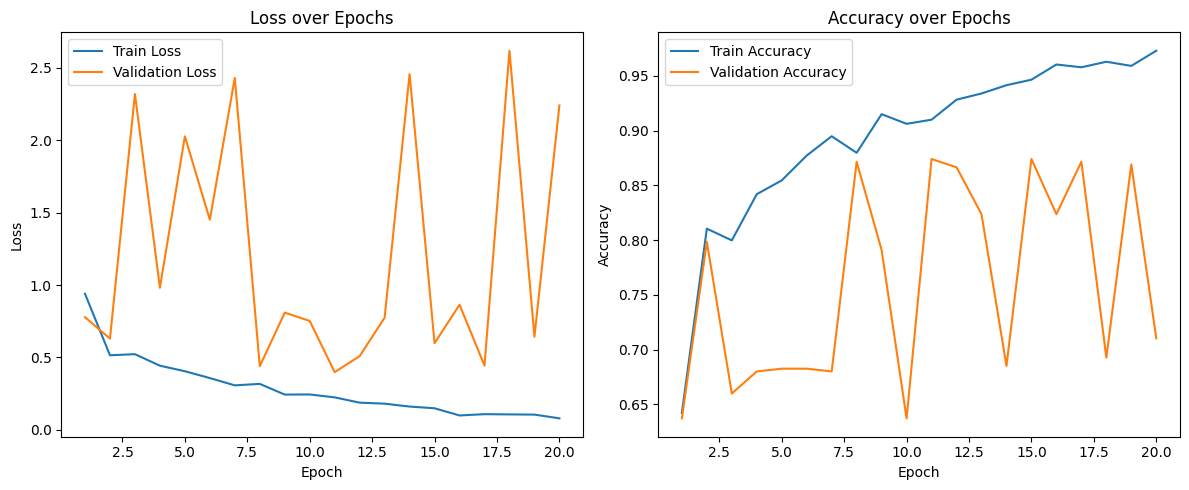

In [ ]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# input_tensor.shape  # might be (1, 2604)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# Load the best saved model (optional but recommended)
model.load_state_dict(torch.load('/content/drive/MyDrive/HeartcareAI/Models/trained/best_ecg_1dcnn.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for signals, labels in val_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=df['Label'].unique().astype(str)))

# Optional: Confusion Matrix
print("\n🧩 Confusion Matrix:\n")
print(confusion_matrix(all_labels, all_preds))



📊 Classification Report:

              precision    recall  f1-score   support

           1       0.82      0.62      0.71        37
           0       0.88      0.96      0.92       247
           2       0.87      0.79      0.83       111
           3       0.00      0.00      0.00         2

    accuracy                           0.87       397
   macro avg       0.64      0.59      0.61       397
weighted avg       0.87      0.87      0.87       397


🧩 Confusion Matrix:

[[ 23   9   5   0]
 [  3 236   8   0]
 [  2  21  88   0]
 [  0   2   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### New: Version 2

In [4]:
"""
ECG preprocessing pipeline for Colab.

Step-1 only: clean and segment ECG into beats, score noise, and export
beat-level + context-window datasets for downstream training.

Example (Colab):
    !pip install -q pandas numpy scipy scikit-learn matplotlib openpyxl neurokit2
    !python colab_ecg_preprocess.py \
        --input /content/723_labelled_multiclass.xlsx \
        --output_dir /content/ecg_preprocessed \
        --duration_sec 10
"""

from __future__ import annotations

import argparse
import json
import math
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

try:
    import neurokit2 as nk  # type: ignore
except Exception:
    nk = None


DEFAULT_LABEL_NAMES = {
    -1: "Noise",
    0: "Normal",
    1: "PAC",
    2: "PVC",
    3: "Sinus Bradycardia",
    4: "Sinus Tachycardia",
    5: "AFib",
    6: "Atrial Flutter",
    7: "VTach",
    8: "VFib",
    9: "Ventricular Ectopic",
    10: "Couplets",
    11: "Triplets",
    12: "PVC Subtypes",
}


@dataclass
class BeatRecord:
    source_row: int
    patient_id: Optional[int]
    record_label: int
    beat_index_in_record: int
    r_index: int
    rr_prev_sec: float
    rr_next_sec: float
    quality_score: float
    noise_flag: bool
    cluster_id: int
    cluster_size: int
    beat: np.ndarray


def robust_zscore(x: np.ndarray) -> np.ndarray:
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-9
    return 0.6745 * (x - med) / mad


def parse_wave(text: object) -> np.ndarray:
    if not isinstance(text, str):
        return np.array([], dtype=np.float32)
    vals = []
    for token in text.split(","):
        token = token.strip()
        if not token:
            continue
        try:
            vals.append(float(token))
        except ValueError:
            return np.array([], dtype=np.float32)
    return np.asarray(vals, dtype=np.float32)


def infer_fs(wave_len: int, duration_sec: float) -> float:
    return float(wave_len) / duration_sec


def bandpass_ecg(wave: np.ndarray, fs: float, low_hz: float = 0.5, high_hz: float = 45.0) -> np.ndarray:
    nyq = fs * 0.5
    high_hz = min(high_hz, nyq - 1e-3)
    if high_hz <= low_hz:
        return wave.astype(np.float32, copy=False)
    b, a = signal.butter(4, [low_hz / nyq, high_hz / nyq], btype="band")
    return signal.filtfilt(b, a, wave).astype(np.float32)


def normalize_wave(wave: np.ndarray) -> np.ndarray:
    mu = float(np.mean(wave))
    sigma = float(np.std(wave)) + 1e-8
    return ((wave - mu) / sigma).astype(np.float32)


def detect_rpeaks(ecg: np.ndarray, fs: float) -> np.ndarray:
    if nk is not None:
        try:
            _, out = nk.ecg_peaks(ecg, sampling_rate=fs, method="neurokit")
            peaks = np.asarray(out["ECG_R_Peaks"], dtype=np.int32)
            if peaks.size > 0:
                return peaks
        except Exception:
            pass

    # Fallback: derivative-energy envelope + peak picking.
    diff = np.diff(ecg, prepend=ecg[0])
    energy = diff * diff
    win = max(3, int(0.12 * fs))
    kernel = np.ones(win, dtype=np.float32) / win
    smooth = np.convolve(energy, kernel, mode="same")
    thr = float(np.mean(smooth) + 0.5 * np.std(smooth))
    min_dist = int(0.24 * fs)  # allow faster rhythms as well
    peaks, _ = signal.find_peaks(smooth, height=thr, distance=max(1, min_dist))
    return peaks.astype(np.int32)


def extract_beats(ecg: np.ndarray, peaks: np.ndarray, fs: float, pre_ms: float, post_ms: float) -> Tuple[np.ndarray, np.ndarray]:
    pre = int(round((pre_ms / 1000.0) * fs))
    post = int(round((post_ms / 1000.0) * fs))
    beats = []
    kept_peaks = []
    for p in peaks:
        left = p - pre
        right = p + post
        if left < 0 or right >= len(ecg):
            continue
        beats.append(ecg[left:right + 1])
        kept_peaks.append(p)
    if not beats:
        return np.empty((0, pre + post + 1), dtype=np.float32), np.empty((0,), dtype=np.int32)
    return np.asarray(beats, dtype=np.float32), np.asarray(kept_peaks, dtype=np.int32)


def beat_quality_features(beats: np.ndarray) -> Dict[str, np.ndarray]:
    ptp = np.ptp(beats, axis=1)
    slope = np.max(np.abs(np.diff(beats, axis=1)), axis=1)
    start = beats[:, : max(4, beats.shape[1] // 10)]
    end = beats[:, -max(4, beats.shape[1] // 10):]
    edge_noise = np.std(np.concatenate([start, end], axis=1), axis=1)
    return {"ptp": ptp, "slope": slope, "edge_noise": edge_noise}


def score_noise(beats: np.ndarray, rr_prev: np.ndarray, rr_next: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    feats = beat_quality_features(beats)
    z_ptp = robust_zscore(feats["ptp"])
    z_slope = robust_zscore(feats["slope"])
    z_edge = robust_zscore(feats["edge_noise"])

    rr_bad = (rr_prev < 0.2) | (rr_prev > 2.5) | (rr_next < 0.2) | (rr_next > 2.5)
    morphology_bad = (z_ptp < -3.0) | (z_slope < -3.0) | (z_edge > 3.5) | (z_slope > 6.0)

    noise = rr_bad | morphology_bad
    score = (np.abs(z_ptp) + np.abs(z_slope) + np.abs(z_edge)) / 3.0
    return score.astype(np.float32), noise.astype(bool)


def dominant_cluster_ids(beats: np.ndarray, max_k: int = 4) -> Tuple[np.ndarray, Dict[int, int]]:
    n = len(beats)
    if n < 12:
        ids = np.zeros((n,), dtype=np.int32)
        return ids, {0: n}
    k = int(np.clip(round(math.sqrt(n / 60.0) + 1), 2, max_k))
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    ids = model.fit_predict(beats)
    sizes = {cid: int(np.sum(ids == cid)) for cid in np.unique(ids)}
    return ids.astype(np.int32), sizes


def resolve_column(df: pd.DataFrame, aliases: List[str]) -> str:
    lower_map = {c.lower().strip(): c for c in df.columns}
    for alias in aliases:
        if alias.lower() in lower_map:
            return lower_map[alias.lower()]
    raise KeyError(f"Missing required column. Tried aliases: {aliases}")


def build_templates(beats: np.ndarray, labels: np.ndarray, noise: np.ndarray) -> Dict[int, np.ndarray]:
    templates: Dict[int, np.ndarray] = {}
    for cls in sorted(np.unique(labels)):
        idx = np.where((labels == cls) & (~noise))[0]
        if idx.size == 0:
            continue
        templates[int(cls)] = np.median(beats[idx], axis=0).astype(np.float32)
    return templates


def build_global_feature_space(
    beats: np.ndarray,
    rr_prev: np.ndarray,
    rr_next: np.ndarray,
    n_pca: int = 24,
) -> np.ndarray:
    """
    Build compact feature vectors for label-free grouping/retrieval.
    Uses beat waveform + RR context ratios.
    """
    rr_prev_col = rr_prev.reshape(-1, 1)
    rr_next_col = rr_next.reshape(-1, 1)
    rr_ratio = (rr_prev_col + 1e-6) / (rr_next_col + 1e-6)
    rr_feat = np.hstack([rr_prev_col, rr_next_col, rr_ratio]).astype(np.float32)

    pca_dim = int(min(n_pca, beats.shape[1], max(2, beats.shape[0] - 1)))
    pca = PCA(n_components=pca_dim, random_state=42)
    beat_emb = pca.fit_transform(beats).astype(np.float32)

    feat = np.hstack([beat_emb, rr_feat]).astype(np.float32)
    feat_mu = feat.mean(axis=0, keepdims=True)
    feat_std = feat.std(axis=0, keepdims=True) + 1e-6
    feat = (feat - feat_mu) / feat_std
    return feat.astype(np.float32)


def cluster_global_beats(
    features: np.ndarray,
    usable_mask: np.ndarray,
    n_clusters: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cluster beats without using labels.
    Returns:
      cluster_id_all: cluster id for each beat (-1 for unusable beats)
      cluster_size_all: cluster size for each beat (0 for unusable beats)
    """
    n = len(features)
    cluster_id_all = np.full((n,), -1, dtype=np.int32)
    cluster_size_all = np.zeros((n,), dtype=np.int32)

    usable_idx = np.where(usable_mask)[0]
    if usable_idx.size < 2:
        return cluster_id_all, cluster_size_all

    k = int(min(n_clusters, usable_idx.size))
    k = max(2, k)
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    ids = model.fit_predict(features[usable_idx]).astype(np.int32)
    cluster_id_all[usable_idx] = ids

    unique_ids, counts = np.unique(ids, return_counts=True)
    size_map = {int(cid): int(c) for cid, c in zip(unique_ids, counts)}
    for idx_local, gidx in enumerate(usable_idx):
        cluster_size_all[gidx] = size_map[int(ids[idx_local])]
    return cluster_id_all, cluster_size_all


def save_global_cluster_plot(
    features: np.ndarray,
    cluster_ids: np.ndarray,
    out_path: Path,
) -> None:
    import matplotlib.pyplot as plt

    usable = cluster_ids >= 0
    if usable.sum() < 3:
        return
    p2 = PCA(n_components=2, random_state=42).fit_transform(features[usable])
    c = cluster_ids[usable]
    plt.figure(figsize=(8, 6))
    plt.scatter(p2[:, 0], p2[:, 1], c=c, s=7, alpha=0.75, cmap="tab20")
    plt.title("Label-Free Beat Clusters (PCA-2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(out_path, dpi=170)
    plt.close()


def seed_similarity_mining(
    features: np.ndarray,
    beat_df: pd.DataFrame,
    seed_csv: str,
    top_k: int,
    search_rows: int,
) -> pd.DataFrame:
    """
    seed_csv format:
      beat_global_id,label_name
      123,PVC
      454,PVC
      700,Normal
    """
    seeds = pd.read_csv(seed_csv)
    required = {"beat_global_id", "label_name"}
    if not required.issubset(set(seeds.columns)):
        raise ValueError(f"seed_csv must contain columns: {required}")

    seeds = seeds.dropna(subset=["beat_global_id", "label_name"]).copy()
    seeds["beat_global_id"] = seeds["beat_global_id"].astype(int)
    valid_seed_ids = [x for x in seeds["beat_global_id"].tolist() if 0 <= x < len(features)]
    if not valid_seed_ids:
        return pd.DataFrame(
            columns=[
                "seed_label",
                "seed_beat_global_id",
                "candidate_beat_global_id",
                "similarity",
                "source_row",
                "patient_id",
                "rr_prev_sec",
                "rr_next_sec",
            ]
        )

    max_row = int(beat_df["source_row"].min()) + int(search_rows) - 1
    candidate_mask = (beat_df["noise_flag"].values == 0) & (beat_df["source_row"].values <= max_row)
    candidate_ids = np.where(candidate_mask)[0]
    if candidate_ids.size == 0:
        return pd.DataFrame()

    rows = []
    for _, srow in seeds.iterrows():
        sid = int(srow["beat_global_id"])
        if sid < 0 or sid >= len(features):
            continue
        seed_label = str(srow["label_name"])
        sim = cosine_similarity(features[sid:sid + 1], features[candidate_ids])[0]
        order = np.argsort(-sim)[:top_k]
        for oid in order:
            gid = int(candidate_ids[oid])
            rows.append(
                {
                    "seed_label": seed_label,
                    "seed_beat_global_id": sid,
                    "candidate_beat_global_id": gid,
                    "similarity": float(sim[oid]),
                    "source_row": int(beat_df.iloc[gid]["source_row"]),
                    "patient_id": int(beat_df.iloc[gid]["patient_id"]),
                    "rr_prev_sec": float(beat_df.iloc[gid]["rr_prev_sec"]),
                    "rr_next_sec": float(beat_df.iloc[gid]["rr_next_sec"]),
                }
            )
    return pd.DataFrame(rows).sort_values(["seed_label", "similarity"], ascending=[True, False])


def save_template_plot(templates: Dict[int, np.ndarray], out_path: Path) -> None:
    import matplotlib.pyplot as plt

    if not templates:
        return
    plt.figure(figsize=(11, 6))
    for cls, tpl in templates.items():
        name = DEFAULT_LABEL_NAMES.get(cls, str(cls))
        plt.plot(tpl, label=f"{cls}: {name}", linewidth=1.6)
    plt.title("Representative Beat Template Per Class")
    plt.xlabel("Sample")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160)
    plt.close()


def make_context_windows(beats: np.ndarray, labels: np.ndarray, source_row: np.ndarray, noise: np.ndarray, window_radius: int = 2) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x_rows = []
    y_rows = []
    mask_rows = []
    beat_len = beats.shape[1]
    group_ids = np.unique(source_row)

    for gid in group_ids:
        idx = np.where((source_row == gid) & (~noise))[0]
        if idx.size == 0:
            continue
        ordered = idx  # already in record order
        for j, center_idx in enumerate(ordered):
            window = []
            mask = []
            for shift in range(-window_radius, window_radius + 1):
                pos = j + shift
                if 0 <= pos < len(ordered):
                    window.append(beats[ordered[pos]])
                    mask.append(1.0)
                else:
                    window.append(np.zeros((beat_len,), dtype=np.float32))
                    mask.append(0.0)
            x_rows.append(np.stack(window, axis=0))
            y_rows.append(labels[center_idx])
            mask_rows.append(np.asarray(mask, dtype=np.float32))

    if not x_rows:
        return (
            np.empty((0, 2 * window_radius + 1, beat_len), dtype=np.float32),
            np.empty((0,), dtype=np.int32),
            np.empty((0, 2 * window_radius + 1), dtype=np.float32),
        )
    return np.asarray(x_rows, dtype=np.float32), np.asarray(y_rows, dtype=np.int32), np.asarray(mask_rows, dtype=np.float32)


def preprocess(args: argparse.Namespace) -> None:
    out_dir = Path(args.output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_excel(args.input)
    wave_col = resolve_column(df, ["ECG Wave", "ecg_wave", "wave"])
    label_col = resolve_column(df, ["Label", "label"])
    patient_col = resolve_column(df, ["Patient ID", "patient_id", "patient"])

    all_beats: List[np.ndarray] = []
    all_labels: List[int] = []
    all_source_row: List[int] = []
    all_patient_id: List[int] = []
    all_r: List[int] = []
    all_rr_prev: List[float] = []
    all_rr_next: List[float] = []
    all_local_index: List[int] = []

    row_stats = []
    skipped_rows = 0

    for ridx, row in df.iterrows():
        wave = parse_wave(row.get(wave_col))
        if wave.size < 200:
            skipped_rows += 1
            continue

        fs = args.fs if args.fs > 0 else infer_fs(len(wave), args.duration_sec)
        ecg = bandpass_ecg(wave, fs=fs, low_hz=args.low_hz, high_hz=args.high_hz)
        ecg = normalize_wave(ecg)
        peaks = detect_rpeaks(ecg, fs=fs)
        beats, kept = extract_beats(ecg, peaks, fs=fs, pre_ms=args.pre_ms, post_ms=args.post_ms)
        if beats.shape[0] == 0:
            skipped_rows += 1
            continue

        label = int(row.get(label_col))
        patient = int(row.get(patient_col)) if pd.notna(row.get(patient_col)) else -1

        rr = np.diff(kept) / fs
        rr_prev = np.concatenate([[rr[0] if rr.size else 1.0], rr]).astype(np.float32)
        rr_next = np.concatenate([rr, [rr[-1] if rr.size else 1.0]]).astype(np.float32)

        for i in range(len(beats)):
            all_beats.append(beats[i])
            all_labels.append(label)
            all_source_row.append(int(ridx))
            all_patient_id.append(patient)
            all_r.append(int(kept[i]))
            all_rr_prev.append(float(rr_prev[i]))
            all_rr_next.append(float(rr_next[i]))
            all_local_index.append(i)

        row_stats.append((int(ridx), int(len(wave)), float(fs), int(len(peaks)), int(len(beats))))

    if not all_beats:
        raise RuntimeError("No beats extracted. Check `duration_sec`, `fs`, or wave format.")

    beats = np.asarray(all_beats, dtype=np.float32)
    labels = np.asarray(all_labels, dtype=np.int32)
    source_row = np.asarray(all_source_row, dtype=np.int32)
    patient_ids = np.asarray(all_patient_id, dtype=np.int32)
    r_idx = np.asarray(all_r, dtype=np.int32)
    rr_prev = np.asarray(all_rr_prev, dtype=np.float32)
    rr_next = np.asarray(all_rr_next, dtype=np.float32)
    local_idx = np.asarray(all_local_index, dtype=np.int32)

    quality_score, noise = score_noise(beats, rr_prev, rr_next)

    # label-aware clustering (optional) to split minor outlier morphologies
    local_cluster_ids = np.full((len(beats),), -1, dtype=np.int32)
    local_cluster_size = np.zeros((len(beats),), dtype=np.int32)
    for cls in sorted(np.unique(labels)):
        idx = np.where((labels == cls) & (~noise))[0]
        if idx.size == 0:
            continue
        ids, sizes = dominant_cluster_ids(beats[idx], max_k=args.max_k_per_class)
        for j, global_idx in enumerate(idx):
            cid = int(ids[j])
            local_cluster_ids[global_idx] = cid
            local_cluster_size[global_idx] = sizes.get(cid, 0)
        tiny_cluster = np.array([sizes[int(ids[j])] < args.min_cluster_size for j in range(len(idx))], dtype=bool)
        noise[idx[tiny_cluster]] = True

    templates = build_templates(beats, labels, noise)
    save_template_plot(templates, out_dir / "class_templates.png")

    # label-free representation map
    features = build_global_feature_space(
        beats=beats,
        rr_prev=rr_prev,
        rr_next=rr_next,
        n_pca=args.feature_pca_dim,
    )
    global_cluster_ids, global_cluster_sizes = cluster_global_beats(
        features=features,
        usable_mask=(~noise),
        n_clusters=args.global_clusters,
    )
    save_global_cluster_plot(features, global_cluster_ids, out_dir / "global_clusters_pca2d.png")

    x_ctx, y_ctx, m_ctx = make_context_windows(
        beats=beats,
        labels=labels,
        source_row=source_row,
        noise=noise,
        window_radius=args.context_radius,
    )

    beat_df = pd.DataFrame(
        {
            "beat_global_id": np.arange(len(beats), dtype=np.int32),
            "source_row": source_row,
            "patient_id": patient_ids,
            "record_label": labels,
            "record_label_name": [DEFAULT_LABEL_NAMES.get(int(x), str(int(x))) for x in labels],
            "beat_index_in_record": local_idx,
            "r_index": r_idx,
            "rr_prev_sec": rr_prev,
            "rr_next_sec": rr_next,
            "quality_score": quality_score,
            "noise_flag": noise.astype(np.int32),
            "local_cluster_id": local_cluster_ids,
            "local_cluster_size": local_cluster_size,
            "global_cluster_id": global_cluster_ids,
            "global_cluster_size": global_cluster_sizes,
        }
    )

    beat_df.to_csv(out_dir / "beat_metadata.csv", index=False)
    np.save(out_dir / "beats.npy", beats)
    np.save(out_dir / "labels.npy", labels)
    np.save(out_dir / "noise_flags.npy", noise.astype(np.int32))
    np.save(out_dir / "features.npy", features)
    np.save(out_dir / "global_cluster_ids.npy", global_cluster_ids)
    np.savez_compressed(out_dir / "context_windows.npz", X=x_ctx, y=y_ctx, mask=m_ctx)
    np.savez_compressed(out_dir / "class_templates.npz", **{f"class_{k}": v for k, v in templates.items()})

    # optional: from 5-10 manually selected seeds, find similar beats in early records
    if args.seed_csv:
        mined = seed_similarity_mining(
            features=features,
            beat_df=beat_df,
            seed_csv=args.seed_csv,
            top_k=args.seed_top_k,
            search_rows=args.seed_search_rows,
        )
        mined.to_csv(out_dir / "seed_mined_candidates.csv", index=False)

    summary = {
        "input_rows": int(len(df)),
        "rows_skipped": int(skipped_rows),
        "beats_extracted": int(len(beats)),
        "beat_length": int(beats.shape[1]),
        "noise_beats": int(np.sum(noise)),
        "usable_beats": int(np.sum(~noise)),
        "class_counts_raw": {str(int(k)): int(np.sum(labels == k)) for k in np.unique(labels)},
        "class_counts_usable": {str(int(k)): int(np.sum((labels == k) & (~noise))) for k in np.unique(labels)},
        "context_samples": int(len(y_ctx)),
        "context_window_size": int(2 * args.context_radius + 1),
        "global_clusters": int(len(np.unique(global_cluster_ids[global_cluster_ids >= 0]))),
        "seed_mining_enabled": bool(args.seed_csv),
    }
    (out_dir / "summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")

    print("Preprocessing complete.")
    print(json.dumps(summary, indent=2))
    print(f"Saved outputs in: {out_dir}")


def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Colab ECG preprocessing for beat-level + context datasets")
    p.add_argument("--input", required=True, help="Path to xlsx file")
    p.add_argument("--output_dir", required=True, help="Directory to save outputs")
    p.add_argument("--duration_sec", type=float, default=10.0, help="Record duration used for fs inference")
    p.add_argument("--fs", type=float, default=-1.0, help="Sampling rate; if <=0 infer from wave length / duration")
    p.add_argument("--low_hz", type=float, default=0.5, help="Bandpass low cutoff")
    p.add_argument("--high_hz", type=float, default=45.0, help="Bandpass high cutoff")
    p.add_argument("--pre_ms", type=float, default=250.0, help="Beat window before R peak")
    p.add_argument("--post_ms", type=float, default=400.0, help="Beat window after R peak")
    p.add_argument("--max_k_per_class", type=int, default=4, help="Max clusters per class for grouping")
    p.add_argument("--min_cluster_size", type=int, default=12, help="Clusters smaller than this are flagged as noise")
    p.add_argument("--context_radius", type=int, default=2, help="Consecutive beat radius (2 -> window of 5)")
    p.add_argument("--feature_pca_dim", type=int, default=24, help="PCA dimensions for label-free beat map")
    p.add_argument("--global_clusters", type=int, default=20, help="Number of global label-free beat clusters")
    p.add_argument("--seed_csv", type=str, default="", help="Optional CSV with columns beat_global_id,label_name")
    p.add_argument("--seed_top_k", type=int, default=50, help="Top similar beats per seed")
    p.add_argument("--seed_search_rows", type=int, default=100, help="Search similar beats in first N records")
    return p.parse_args()


if __name__ == "__main__":
    # Supports both styles:
    # 1) CLI: python colab_ecg_preprocess.py --input ... --output_dir ...
    # 2) Direct notebook run with no CLI args (uses editable defaults below)
    cli_has_required = ("--input" in sys.argv) and ("--output_dir" in sys.argv)
    if cli_has_required:
        preprocess(parse_args())
    else:
        class Args:
            def __init__(self):
                self.input = "/content/drive/MyDrive/HeartcareAI/Models/LabelledData/723_labelled_multiclass.xlsx"
                self.output_dir = "/content/ecg_preprocessed"
                self.duration_sec = 10.0
                self.fs = -1.0
                self.low_hz = 0.5
                self.high_hz = 45.0
                self.pre_ms = 250.0
                self.post_ms = 400.0
                self.max_k_per_class = 4
                self.min_cluster_size = 12
                self.context_radius = 2
                self.feature_pca_dim = 24
                self.global_clusters = 20
                self.seed_csv = ""
                self.seed_top_k = 50
                self.seed_search_rows = 100

        preprocess(Args())

Preprocessing complete.
{
  "input_rows": 1985,
  "rows_skipped": 0,
  "beats_extracted": 21860,
  "beat_length": 170,
  "noise_beats": 1577,
  "usable_beats": 20283,
  "class_counts_raw": {
    "-1": 2223,
    "0": 13378,
    "2": 6113,
    "3": 146
  },
  "class_counts_usable": {
    "-1": 1086,
    "0": 13176,
    "2": 5885,
    "3": 136
  },
  "context_samples": 20283,
  "context_window_size": 5,
  "global_clusters": 20,
  "seed_mining_enabled": false
}
Saved outputs in: /content/ecg_preprocessed


### Updated: Version 3

In [7]:
"""
ECG preprocessing pipeline for Colab.

Step-1 only: clean and segment ECG into beats, score noise, and export
beat-level + context-window datasets for downstream training.

BLOCK 1 (Colab install):
    !pip install -q pandas numpy scipy scikit-learn matplotlib openpyxl neurokit2

BLOCK 2 (Run script with CLI args):
    !pip install -q pandas numpy scipy scikit-learn matplotlib openpyxl neurokit2
    !python colab_ecg_preprocess.py \
        --input /content/723_labelled_multiclass.xlsx \
        --output_dir /content/ecg_preprocessed \
        --duration_sec 10

BLOCK 3 (View outputs):
    from IPython.display import Image, display
    display(Image('/content/ecg_preprocessed/class_templates.png'))
    display(Image('/content/ecg_preprocessed/global_clusters_pca2d.png'))
    display(Image('/content/ecg_preprocessed/prototype_gallery.png'))

BLOCK 4 (Inspect prototype map):
    import pandas as pd
    pd.read_csv('/content/ecg_preprocessed/prototype_library.csv').head(20)

BLOCK 5 (Inspect key-value prototypes anytime):
    from colab_ecg_preprocess import inspect_prototype_keys
    inspect_prototype_keys('/content/ecg_preprocessed', top_n=20)

BLOCK 6 (Plot prototypes for one label):
    from colab_ecg_preprocess import plot_label_prototypes
    plot_label_prototypes('/content/ecg_preprocessed', label_id=2)
"""

from __future__ import annotations

import argparse
import json
import math
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

try:
    import neurokit2 as nk  # type: ignore
except Exception:
    nk = None


DEFAULT_LABEL_NAMES = {
    -1: "Noise",
    0: "Normal",
    1: "PAC",
    2: "PVC",
    3: "Sinus Bradycardia",
    4: "Sinus Tachycardia",
    5: "AFib",
    6: "Atrial Flutter",
    7: "VTach",
    8: "VFib",
    9: "Ventricular Ectopic",
    10: "Couplets",
    11: "Triplets",
    12: "PVC Subtypes",
}


# =========================
# BLOCK A: Core Utilities
# =========================
@dataclass
class BeatRecord:
    source_row: int
    patient_id: Optional[int]
    record_label: int
    beat_index_in_record: int
    r_index: int
    rr_prev_sec: float
    rr_next_sec: float
    quality_score: float
    noise_flag: bool
    cluster_id: int
    cluster_size: int
    beat: np.ndarray


def robust_zscore(x: np.ndarray) -> np.ndarray:
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-9
    return 0.6745 * (x - med) / mad


def parse_wave(text: object) -> np.ndarray:
    if not isinstance(text, str):
        return np.array([], dtype=np.float32)
    vals = []
    for token in text.split(","):
        token = token.strip()
        if not token:
            continue
        try:
            vals.append(float(token))
        except ValueError:
            return np.array([], dtype=np.float32)
    return np.asarray(vals, dtype=np.float32)


def infer_fs(wave_len: int, duration_sec: float) -> float:
    return float(wave_len) / duration_sec


def bandpass_ecg(wave: np.ndarray, fs: float, low_hz: float = 0.5, high_hz: float = 45.0) -> np.ndarray:
    nyq = fs * 0.5
    high_hz = min(high_hz, nyq - 1e-3)
    if high_hz <= low_hz:
        return wave.astype(np.float32, copy=False)
    b, a = signal.butter(4, [low_hz / nyq, high_hz / nyq], btype="band")
    return signal.filtfilt(b, a, wave).astype(np.float32)


def normalize_wave(wave: np.ndarray) -> np.ndarray:
    mu = float(np.mean(wave))
    sigma = float(np.std(wave)) + 1e-8
    return ((wave - mu) / sigma).astype(np.float32)


def detect_rpeaks(ecg: np.ndarray, fs: float) -> np.ndarray:
    if nk is not None:
        try:
            _, out = nk.ecg_peaks(ecg, sampling_rate=fs, method="neurokit")
            peaks = np.asarray(out["ECG_R_Peaks"], dtype=np.int32)
            if peaks.size > 0:
                return peaks
        except Exception:
            pass

    # Fallback: derivative-energy envelope + peak picking.
    diff = np.diff(ecg, prepend=ecg[0])
    energy = diff * diff
    win = max(3, int(0.12 * fs))
    kernel = np.ones(win, dtype=np.float32) / win
    smooth = np.convolve(energy, kernel, mode="same")
    thr = float(np.mean(smooth) + 0.5 * np.std(smooth))
    min_dist = int(0.24 * fs)  # allow faster rhythms as well
    peaks, _ = signal.find_peaks(smooth, height=thr, distance=max(1, min_dist))
    return peaks.astype(np.int32)


def extract_beats(ecg: np.ndarray, peaks: np.ndarray, fs: float, pre_ms: float, post_ms: float) -> Tuple[np.ndarray, np.ndarray]:
    pre = int(round((pre_ms / 1000.0) * fs))
    post = int(round((post_ms / 1000.0) * fs))
    beats = []
    kept_peaks = []
    for p in peaks:
        left = p - pre
        right = p + post
        if left < 0 or right >= len(ecg):
            continue
        beats.append(ecg[left:right + 1])
        kept_peaks.append(p)
    if not beats:
        return np.empty((0, pre + post + 1), dtype=np.float32), np.empty((0,), dtype=np.int32)
    return np.asarray(beats, dtype=np.float32), np.asarray(kept_peaks, dtype=np.int32)


def beat_quality_features(beats: np.ndarray) -> Dict[str, np.ndarray]:
    ptp = np.ptp(beats, axis=1)
    slope = np.max(np.abs(np.diff(beats, axis=1)), axis=1)
    start = beats[:, : max(4, beats.shape[1] // 10)]
    end = beats[:, -max(4, beats.shape[1] // 10):]
    edge_noise = np.std(np.concatenate([start, end], axis=1), axis=1)
    return {"ptp": ptp, "slope": slope, "edge_noise": edge_noise}


def score_noise(beats: np.ndarray, rr_prev: np.ndarray, rr_next: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    feats = beat_quality_features(beats)
    z_ptp = robust_zscore(feats["ptp"])
    z_slope = robust_zscore(feats["slope"])
    z_edge = robust_zscore(feats["edge_noise"])

    rr_bad = (rr_prev < 0.2) | (rr_prev > 2.5) | (rr_next < 0.2) | (rr_next > 2.5)
    morphology_bad = (z_ptp < -3.0) | (z_slope < -3.0) | (z_edge > 3.5) | (z_slope > 6.0)

    noise = rr_bad | morphology_bad
    score = (np.abs(z_ptp) + np.abs(z_slope) + np.abs(z_edge)) / 3.0
    return score.astype(np.float32), noise.astype(bool)


def dominant_cluster_ids(beats: np.ndarray, max_k: int = 4) -> Tuple[np.ndarray, Dict[int, int]]:
    n = len(beats)
    if n < 12:
        ids = np.zeros((n,), dtype=np.int32)
        return ids, {0: n}
    k = int(np.clip(round(math.sqrt(n / 60.0) + 1), 2, max_k))
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    ids = model.fit_predict(beats)
    sizes = {cid: int(np.sum(ids == cid)) for cid in np.unique(ids)}
    return ids.astype(np.int32), sizes


def resolve_column(df: pd.DataFrame, aliases: List[str]) -> str:
    lower_map = {c.lower().strip(): c for c in df.columns}
    for alias in aliases:
        if alias.lower() in lower_map:
            return lower_map[alias.lower()]
    raise KeyError(f"Missing required column. Tried aliases: {aliases}")


def build_templates(beats: np.ndarray, labels: np.ndarray, noise: np.ndarray) -> Dict[int, np.ndarray]:
    templates: Dict[int, np.ndarray] = {}
    for cls in sorted(np.unique(labels)):
        idx = np.where((labels == cls) & (~noise))[0]
        if idx.size == 0:
            continue
        templates[int(cls)] = np.median(beats[idx], axis=0).astype(np.float32)
    return templates


def build_global_feature_space(
    beats: np.ndarray,
    rr_prev: np.ndarray,
    rr_next: np.ndarray,
    n_pca: int = 24,
) -> np.ndarray:
    """
    Build compact feature vectors for label-free grouping/retrieval.
    Uses beat waveform + RR context ratios.
    """
    rr_prev_col = rr_prev.reshape(-1, 1)
    rr_next_col = rr_next.reshape(-1, 1)
    rr_ratio = (rr_prev_col + 1e-6) / (rr_next_col + 1e-6)
    rr_feat = np.hstack([rr_prev_col, rr_next_col, rr_ratio]).astype(np.float32)

    pca_dim = int(min(n_pca, beats.shape[1], max(2, beats.shape[0] - 1)))
    pca = PCA(n_components=pca_dim, random_state=42)
    beat_emb = pca.fit_transform(beats).astype(np.float32)

    feat = np.hstack([beat_emb, rr_feat]).astype(np.float32)
    feat_mu = feat.mean(axis=0, keepdims=True)
    feat_std = feat.std(axis=0, keepdims=True) + 1e-6
    feat = (feat - feat_mu) / feat_std
    return feat.astype(np.float32)


def cluster_global_beats(
    features: np.ndarray,
    usable_mask: np.ndarray,
    n_clusters: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cluster beats without using labels.
    Returns:
      cluster_id_all: cluster id for each beat (-1 for unusable beats)
      cluster_size_all: cluster size for each beat (0 for unusable beats)
    """
    n = len(features)
    cluster_id_all = np.full((n,), -1, dtype=np.int32)
    cluster_size_all = np.zeros((n,), dtype=np.int32)

    usable_idx = np.where(usable_mask)[0]
    if usable_idx.size < 2:
        return cluster_id_all, cluster_size_all

    k = int(min(n_clusters, usable_idx.size))
    k = max(2, k)
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    ids = model.fit_predict(features[usable_idx]).astype(np.int32)
    cluster_id_all[usable_idx] = ids

    unique_ids, counts = np.unique(ids, return_counts=True)
    size_map = {int(cid): int(c) for cid, c in zip(unique_ids, counts)}
    for idx_local, gidx in enumerate(usable_idx):
        cluster_size_all[gidx] = size_map[int(ids[idx_local])]
    return cluster_id_all, cluster_size_all


def save_global_cluster_plot(
    features: np.ndarray,
    cluster_ids: np.ndarray,
    out_path: Path,
) -> None:
    import matplotlib.pyplot as plt

    usable = cluster_ids >= 0
    if usable.sum() < 3:
        return
    p2 = PCA(n_components=2, random_state=42).fit_transform(features[usable])
    c = cluster_ids[usable]
    plt.figure(figsize=(8, 6))
    plt.scatter(p2[:, 0], p2[:, 1], c=c, s=7, alpha=0.75, cmap="tab20")
    plt.title("Label-Free Beat Clusters (PCA-2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(out_path, dpi=170)
    plt.close()


def build_prototype_library(
    beats: np.ndarray,
    labels: np.ndarray,
    noise: np.ndarray,
    global_cluster_ids: np.ndarray,
    rr_prev: np.ndarray,
    rr_next: np.ndarray,
) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:
    """
    Build key-value prototype map:
      key   -> prototype_id (global cluster id)
      value -> centroid/median beat waveform + stats
    """
    rows = []
    wave_map: Dict[str, np.ndarray] = {}
    usable_idx = np.where((~noise) & (global_cluster_ids >= 0))[0]
    if usable_idx.size == 0:
        return pd.DataFrame(), wave_map

    cids = np.unique(global_cluster_ids[usable_idx])
    for cid in cids:
        idx = np.where((global_cluster_ids == cid) & (~noise))[0]
        if idx.size == 0:
            continue

        cluster_beats = beats[idx]
        prototype = np.median(cluster_beats, axis=0).astype(np.float32)
        wave_map[f"prototype_{int(cid)}"] = prototype

        cls_vals, cls_counts = np.unique(labels[idx], return_counts=True)
        order = np.argsort(-cls_counts)
        top_pairs = [(int(cls_vals[i]), int(cls_counts[i])) for i in order[:3]]
        top_text = ";".join([f"{k}:{v}" for k, v in top_pairs])

        rows.append(
            {
                "prototype_id": int(cid),
                "size": int(idx.size),
                "dominant_label": int(top_pairs[0][0]) if top_pairs else -999,
                "label_mix_top3": top_text,
                "rr_prev_mean": float(np.mean(rr_prev[idx])),
                "rr_next_mean": float(np.mean(rr_next[idx])),
                "example_beat_ids": ",".join(map(str, idx[:10].tolist())),
            }
        )

    proto_df = pd.DataFrame(rows).sort_values("size", ascending=False)
    return proto_df, wave_map


def save_prototype_gallery(
    proto_df: pd.DataFrame,
    wave_map: Dict[str, np.ndarray],
    out_path: Path,
    max_items: int = 25,
) -> None:
    import matplotlib.pyplot as plt

    if proto_df.empty:
        return
    show_df = proto_df.head(max_items)
    n = len(show_df)
    cols = 5
    rows = int(math.ceil(n / cols))
    plt.figure(figsize=(3.2 * cols, 2.2 * rows))
    for i, (_, r) in enumerate(show_df.iterrows(), start=1):
        pid = int(r["prototype_id"])
        w = wave_map.get(f"prototype_{pid}")
        if w is None:
            continue
        ax = plt.subplot(rows, cols, i)
        ax.plot(w, linewidth=1.4)
        ax.set_title(f"P{pid} n={int(r['size'])}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(out_path, dpi=170)
    plt.close()


def seed_similarity_mining(
    features: np.ndarray,
    beat_df: pd.DataFrame,
    seed_csv: str,
    top_k: int,
    search_rows: int,
) -> pd.DataFrame:
    """
    seed_csv format:
      beat_global_id,label_name
      123,PVC
      454,PVC
      700,Normal
    """
    seeds = pd.read_csv(seed_csv)
    required = {"beat_global_id", "label_name"}
    if not required.issubset(set(seeds.columns)):
        raise ValueError(f"seed_csv must contain columns: {required}")

    seeds = seeds.dropna(subset=["beat_global_id", "label_name"]).copy()
    seeds["beat_global_id"] = seeds["beat_global_id"].astype(int)
    valid_seed_ids = [x for x in seeds["beat_global_id"].tolist() if 0 <= x < len(features)]
    if not valid_seed_ids:
        return pd.DataFrame(
            columns=[
                "seed_label",
                "seed_beat_global_id",
                "candidate_beat_global_id",
                "similarity",
                "source_row",
                "patient_id",
                "rr_prev_sec",
                "rr_next_sec",
            ]
        )

    max_row = int(beat_df["source_row"].min()) + int(search_rows) - 1
    candidate_mask = (beat_df["noise_flag"].values == 0) & (beat_df["source_row"].values <= max_row)
    candidate_ids = np.where(candidate_mask)[0]
    if candidate_ids.size == 0:
        return pd.DataFrame()

    rows = []
    for _, srow in seeds.iterrows():
        sid = int(srow["beat_global_id"])
        if sid < 0 or sid >= len(features):
            continue
        seed_label = str(srow["label_name"])
        sim = cosine_similarity(features[sid:sid + 1], features[candidate_ids])[0]
        order = np.argsort(-sim)[:top_k]
        for oid in order:
            gid = int(candidate_ids[oid])
            rows.append(
                {
                    "seed_label": seed_label,
                    "seed_beat_global_id": sid,
                    "candidate_beat_global_id": gid,
                    "similarity": float(sim[oid]),
                    "source_row": int(beat_df.iloc[gid]["source_row"]),
                    "patient_id": int(beat_df.iloc[gid]["patient_id"]),
                    "rr_prev_sec": float(beat_df.iloc[gid]["rr_prev_sec"]),
                    "rr_next_sec": float(beat_df.iloc[gid]["rr_next_sec"]),
                }
            )
    return pd.DataFrame(rows).sort_values(["seed_label", "similarity"], ascending=[True, False])


def save_template_plot(templates: Dict[int, np.ndarray], out_path: Path) -> None:
    import matplotlib.pyplot as plt

    if not templates:
        return
    plt.figure(figsize=(11, 6))
    for cls, tpl in templates.items():
        name = DEFAULT_LABEL_NAMES.get(cls, str(cls))
        plt.plot(tpl, label=f"{cls}: {name}", linewidth=1.6)
    plt.title("Representative Beat Template Per Class")
    plt.xlabel("Sample")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160)
    plt.close()


def make_context_windows(beats: np.ndarray, labels: np.ndarray, source_row: np.ndarray, noise: np.ndarray, window_radius: int = 2) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x_rows = []
    y_rows = []
    mask_rows = []
    beat_len = beats.shape[1]
    group_ids = np.unique(source_row)

    for gid in group_ids:
        idx = np.where((source_row == gid) & (~noise))[0]
        if idx.size == 0:
            continue
        ordered = idx  # already in record order
        for j, center_idx in enumerate(ordered):
            window = []
            mask = []
            for shift in range(-window_radius, window_radius + 1):
                pos = j + shift
                if 0 <= pos < len(ordered):
                    window.append(beats[ordered[pos]])
                    mask.append(1.0)
                else:
                    window.append(np.zeros((beat_len,), dtype=np.float32))
                    mask.append(0.0)
            x_rows.append(np.stack(window, axis=0))
            y_rows.append(labels[center_idx])
            mask_rows.append(np.asarray(mask, dtype=np.float32))

    if not x_rows:
        return (
            np.empty((0, 2 * window_radius + 1, beat_len), dtype=np.float32),
            np.empty((0,), dtype=np.int32),
            np.empty((0, 2 * window_radius + 1), dtype=np.float32),
        )
    return np.asarray(x_rows, dtype=np.float32), np.asarray(y_rows, dtype=np.int32), np.asarray(mask_rows, dtype=np.float32)


def preprocess(args: argparse.Namespace) -> None:
    # =========================
    # BLOCK B: Load Input Data
    # =========================
    out_dir = Path(args.output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_excel(args.input)
    wave_col = resolve_column(df, ["ECG Wave", "ecg_wave", "wave"])
    label_col = resolve_column(df, ["Label", "label"])
    patient_col = resolve_column(df, ["Patient ID", "patient_id", "patient"])

    all_beats: List[np.ndarray] = []
    all_labels: List[int] = []
    all_source_row: List[int] = []
    all_patient_id: List[int] = []
    all_r: List[int] = []
    all_rr_prev: List[float] = []
    all_rr_next: List[float] = []
    all_local_index: List[int] = []

    row_stats = []
    skipped_rows = 0

    # ============================================
    # BLOCK C: Per-record signal -> beat extraction
    # ============================================
    for ridx, row in df.iterrows():
        wave = parse_wave(row.get(wave_col))
        if wave.size < 200:
            skipped_rows += 1
            continue

        fs = args.fs if args.fs > 0 else infer_fs(len(wave), args.duration_sec)
        ecg = bandpass_ecg(wave, fs=fs, low_hz=args.low_hz, high_hz=args.high_hz)
        ecg = normalize_wave(ecg)
        peaks = detect_rpeaks(ecg, fs=fs)
        beats, kept = extract_beats(ecg, peaks, fs=fs, pre_ms=args.pre_ms, post_ms=args.post_ms)
        if beats.shape[0] == 0:
            skipped_rows += 1
            continue

        label = int(row.get(label_col))
        patient = int(row.get(patient_col)) if pd.notna(row.get(patient_col)) else -1

        rr = np.diff(kept) / fs
        rr_prev = np.concatenate([[rr[0] if rr.size else 1.0], rr]).astype(np.float32)
        rr_next = np.concatenate([rr, [rr[-1] if rr.size else 1.0]]).astype(np.float32)

        for i in range(len(beats)):
            all_beats.append(beats[i])
            all_labels.append(label)
            all_source_row.append(int(ridx))
            all_patient_id.append(patient)
            all_r.append(int(kept[i]))
            all_rr_prev.append(float(rr_prev[i]))
            all_rr_next.append(float(rr_next[i]))
            all_local_index.append(i)

        row_stats.append((int(ridx), int(len(wave)), float(fs), int(len(peaks)), int(len(beats))))

    if not all_beats:
        raise RuntimeError("No beats extracted. Check `duration_sec`, `fs`, or wave format.")

    beats = np.asarray(all_beats, dtype=np.float32)
    labels = np.asarray(all_labels, dtype=np.int32)
    source_row = np.asarray(all_source_row, dtype=np.int32)
    patient_ids = np.asarray(all_patient_id, dtype=np.int32)
    r_idx = np.asarray(all_r, dtype=np.int32)
    rr_prev = np.asarray(all_rr_prev, dtype=np.float32)
    rr_next = np.asarray(all_rr_next, dtype=np.float32)
    local_idx = np.asarray(all_local_index, dtype=np.int32)

    # ============================
    # BLOCK D: Noise score + filter
    # ============================
    quality_score, noise = score_noise(beats, rr_prev, rr_next)

    # label-aware clustering (optional) to split minor outlier morphologies
    local_cluster_ids = np.full((len(beats),), -1, dtype=np.int32)
    local_cluster_size = np.zeros((len(beats),), dtype=np.int32)
    for cls in sorted(np.unique(labels)):
        idx = np.where((labels == cls) & (~noise))[0]
        if idx.size == 0:
            continue
        ids, sizes = dominant_cluster_ids(beats[idx], max_k=args.max_k_per_class)
        for j, global_idx in enumerate(idx):
            cid = int(ids[j])
            local_cluster_ids[global_idx] = cid
            local_cluster_size[global_idx] = sizes.get(cid, 0)
        tiny_cluster = np.array([sizes[int(ids[j])] < args.min_cluster_size for j in range(len(idx))], dtype=bool)
        noise[idx[tiny_cluster]] = True

    # ==================================
    # BLOCK E: Build pattern templates/map
    # ==================================
    templates = build_templates(beats, labels, noise)
    save_template_plot(templates, out_dir / "class_templates.png")

    # label-free representation map
    features = build_global_feature_space(
        beats=beats,
        rr_prev=rr_prev,
        rr_next=rr_next,
        n_pca=args.feature_pca_dim,
    )
    global_cluster_ids, global_cluster_sizes = cluster_global_beats(
        features=features,
        usable_mask=(~noise),
        n_clusters=args.global_clusters,
    )
    save_global_cluster_plot(features, global_cluster_ids, out_dir / "global_clusters_pca2d.png")

    # =========================================
    # BLOCK F: Build consecutive context windows
    # =========================================
    x_ctx, y_ctx, m_ctx = make_context_windows(
        beats=beats,
        labels=labels,
        source_row=source_row,
        noise=noise,
        window_radius=args.context_radius,
    )

    beat_df = pd.DataFrame(
        {
            "beat_global_id": np.arange(len(beats), dtype=np.int32),
            "source_row": source_row,
            "patient_id": patient_ids,
            "record_label": labels,
            "record_label_name": [DEFAULT_LABEL_NAMES.get(int(x), str(int(x))) for x in labels],
            "beat_index_in_record": local_idx,
            "r_index": r_idx,
            "rr_prev_sec": rr_prev,
            "rr_next_sec": rr_next,
            "quality_score": quality_score,
            "noise_flag": noise.astype(np.int32),
            "local_cluster_id": local_cluster_ids,
            "local_cluster_size": local_cluster_size,
            "global_cluster_id": global_cluster_ids,
            "global_cluster_size": global_cluster_sizes,
        }
    )

    # =============================
    # BLOCK G: Save core artefacts
    # =============================
    beat_df.to_csv(out_dir / "beat_metadata.csv", index=False)
    np.save(out_dir / "beats.npy", beats)
    np.save(out_dir / "labels.npy", labels)
    np.save(out_dir / "noise_flags.npy", noise.astype(np.int32))
    np.save(out_dir / "features.npy", features)
    np.save(out_dir / "global_cluster_ids.npy", global_cluster_ids)
    np.savez_compressed(out_dir / "context_windows.npz", X=x_ctx, y=y_ctx, mask=m_ctx)
    np.savez_compressed(out_dir / "class_templates.npz", **{f"class_{k}": v for k, v in templates.items()})

    # =======================================
    # BLOCK H: Save prototype key-value library
    # =======================================
    # Key-value prototype map (label-free)
    proto_df, proto_wave_map = build_prototype_library(
        beats=beats,
        labels=labels,
        noise=noise,
        global_cluster_ids=global_cluster_ids,
        rr_prev=rr_prev,
        rr_next=rr_next,
    )
    if not proto_df.empty:
        proto_df.to_csv(out_dir / "prototype_library.csv", index=False)
        np.savez_compressed(out_dir / "prototype_library_waves.npz", **proto_wave_map)
        save_prototype_gallery(proto_df, proto_wave_map, out_dir / "prototype_gallery.png")

    # ==========================================
    # BLOCK I: Optional seed-based similar mining
    # ==========================================
    # optional: from 5-10 manually selected seeds, find similar beats in early records
    if args.seed_csv:
        mined = seed_similarity_mining(
            features=features,
            beat_df=beat_df,
            seed_csv=args.seed_csv,
            top_k=args.seed_top_k,
            search_rows=args.seed_search_rows,
        )
        mined.to_csv(out_dir / "seed_mined_candidates.csv", index=False)

    # =========================
    # BLOCK J: Summary outputs
    # =========================
    summary = {
        "input_rows": int(len(df)),
        "rows_skipped": int(skipped_rows),
        "beats_extracted": int(len(beats)),
        "beat_length": int(beats.shape[1]),
        "noise_beats": int(np.sum(noise)),
        "usable_beats": int(np.sum(~noise)),
        "class_counts_raw": {str(int(k)): int(np.sum(labels == k)) for k in np.unique(labels)},
        "class_counts_usable": {str(int(k)): int(np.sum((labels == k) & (~noise))) for k in np.unique(labels)},
        "context_samples": int(len(y_ctx)),
        "context_window_size": int(2 * args.context_radius + 1),
        "global_clusters": int(len(np.unique(global_cluster_ids[global_cluster_ids >= 0]))),
        "prototype_count": int(len(proto_df)),
        "seed_mining_enabled": bool(args.seed_csv),
    }
    (out_dir / "summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")

    print("Preprocessing complete.")
    print(json.dumps(summary, indent=2))
    print(f"Saved outputs in: {out_dir}")


# =========================
# BLOCK K: Runtime / CLI
# =========================
def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Colab ECG preprocessing for beat-level + context datasets")
    p.add_argument("--input", required=True, help="Path to xlsx file")
    p.add_argument("--output_dir", required=True, help="Directory to save outputs")
    p.add_argument("--duration_sec", type=float, default=10.0, help="Record duration used for fs inference")
    p.add_argument("--fs", type=float, default=-1.0, help="Sampling rate; if <=0 infer from wave length / duration")
    p.add_argument("--low_hz", type=float, default=0.5, help="Bandpass low cutoff")
    p.add_argument("--high_hz", type=float, default=45.0, help="Bandpass high cutoff")
    p.add_argument("--pre_ms", type=float, default=250.0, help="Beat window before R peak")
    p.add_argument("--post_ms", type=float, default=400.0, help="Beat window after R peak")
    p.add_argument("--max_k_per_class", type=int, default=4, help="Max clusters per class for grouping")
    p.add_argument("--min_cluster_size", type=int, default=12, help="Clusters smaller than this are flagged as noise")
    p.add_argument("--context_radius", type=int, default=2, help="Consecutive beat radius (2 -> window of 5)")
    p.add_argument("--feature_pca_dim", type=int, default=24, help="PCA dimensions for label-free beat map")
    p.add_argument("--global_clusters", type=int, default=20, help="Number of global label-free beat clusters")
    p.add_argument("--seed_csv", type=str, default="", help="Optional CSV with columns beat_global_id,label_name")
    p.add_argument("--seed_top_k", type=int, default=50, help="Top similar beats per seed")
    p.add_argument("--seed_search_rows", type=int, default=100, help="Search similar beats in first N records")
    return p.parse_args()


def visualize_preprocessed_data(output_dir: str) -> None:
    """
    Utility function to visualize the extracted beat templates and global clusters
    directly inside a Colab Notebook cell block.

    Example to run in Colab after preprocessing:
        from colab_ecg_preprocess import visualize_preprocessed_data
        visualize_preprocessed_data("/content/ecg_preprocessed")
    """
    import matplotlib.pyplot as plt
    try:
        from IPython.display import display
        is_notebook = True
    except ImportError:
        is_notebook = False

    out_dir = Path(output_dir)

    print("=== Loading Class Templates ===")
    npz_path = out_dir / "class_templates.npz"
    if npz_path.exists():
        data = np.load(npz_path)
        classes = sorted(data.files, key=lambda x: int(x.split('_')[1]))

        n_classes = len(classes)
        cols = min(4, n_classes) if n_classes > 0 else 1
        rows = (n_classes + cols - 1) // cols

        if n_classes > 0:
            plt.figure(figsize=(15, 3 * rows))
            for i, cls_key in enumerate(classes):
                plt.subplot(rows, cols, i + 1)
                plt.plot(data[cls_key], color='#1f77b4', linewidth=1.5)
                plt.title(f"Template: {cls_key.replace('_', ' ')}")
                plt.xlabel("Sample")
                plt.ylabel("Normalized Amplitude")
                plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("No class templates found in file.")
    else:
        print(f"File not found: {npz_path}")

    print("\n=== Loading Label-Free Beat Clusters ===")
    feats_path = out_dir / "features.npy"
    cluster_ids_path = out_dir / "global_cluster_ids.npy"

    if feats_path.exists() and cluster_ids_path.exists():
        features = np.load(feats_path)
        cluster_ids = np.load(cluster_ids_path)
        usable = cluster_ids >= 0
        if usable.sum() > 2:
            p2 = PCA(n_components=2, random_state=42).fit_transform(features[usable])
            c = cluster_ids[usable]

            plt.figure(figsize=(8, 6))
            sc = plt.scatter(p2[:, 0], p2[:, 1], c=c, s=15, alpha=0.7, cmap="tab20")
            plt.title("Label-Free Beat Clusters (PCA-2D)")
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.colorbar(sc, label="Global Cluster ID")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough usable beats to plot clusters.")
    else:
        print(f"Cluster/Feature files not found in {out_dir}")


def inspect_prototype_keys(output_dir: str, top_n: int = 20) -> None:
    """
    Quick key-value inspector for prototype library.
    Shows:
      - key = prototype_id
      - value = waveform array name in prototype_library_waves.npz
      - stats = size, dominant label, label mix, example beat ids
    """
    out_dir = Path(output_dir)
    csv_path = out_dir / "prototype_library.csv"
    npz_path = out_dir / "prototype_library_waves.npz"

    if not csv_path.exists():
        print(f"Not found: {csv_path}")
        return
    if not npz_path.exists():
        print(f"Not found: {npz_path}")
        return

    df = pd.read_csv(csv_path).sort_values("size", ascending=False).head(top_n)
    waves = np.load(npz_path)

    print(f"Showing top {len(df)} prototype keys from: {out_dir}")
    for _, r in df.iterrows():
        pid = int(r["prototype_id"])
        key = f"prototype_{pid}"
        has_wave = key in waves.files
        shape = tuple(waves[key].shape) if has_wave else None
        print(
            f"key={key:<14} "
            f"size={int(r['size']):<5} "
            f"dominant_label={int(r['dominant_label']):<3} "
            f"mix={r['label_mix_top3']} "
            f"wave_shape={shape}"
        )


def plot_label_prototypes(output_dir: str, label_id: int) -> None:
    """
    Plot prototype waveforms for one dominant label.
    Example:
        plot_label_prototypes('/content/ecg_preprocessed', label_id=2)
    """
    import matplotlib.pyplot as plt

    out_dir = Path(output_dir)
    csv_path = out_dir / "prototype_library.csv"
    npz_path = out_dir / "prototype_library_waves.npz"

    if not csv_path.exists():
        print(f"Not found: {csv_path}")
        return
    if not npz_path.exists():
        print(f"Not found: {npz_path}")
        return

    proto = pd.read_csv(csv_path)
    waves = np.load(npz_path)
    rows = proto[proto["dominant_label"] == int(label_id)].sort_values("size", ascending=False)

    print(f"Found {len(rows)} prototypes for label {label_id} ({DEFAULT_LABEL_NAMES.get(label_id, 'Unknown')})")
    if rows.empty:
        return

    plt.figure(figsize=(12, 5))
    for _, r in rows.iterrows():
        pid = int(r["prototype_id"])
        key = f"prototype_{pid}"
        if key not in waves.files:
            continue
        w = waves[key]
        plt.plot(w, label=f"P{pid} n={int(r['size'])}", alpha=0.9)
    plt.title(f"Prototype Patterns for Label {label_id} - {DEFAULT_LABEL_NAMES.get(label_id, 'Unknown')}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(fontsize=8)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Supports both styles:
    # 1) CLI: python colab_ecg_preprocess.py --input ... --output_dir ...
    # 2) Direct notebook run with no CLI args (uses editable defaults below)
    cli_has_required = ("--input" in sys.argv) and ("--output_dir" in sys.argv)
    if cli_has_required:
        preprocess(parse_args())
    else:
        class Args:
            def __init__(self):
                self.input = "/content/drive/MyDrive/HeartcareAI/Models/LabelledData/723_labelled_multiclass.xlsx"
                self.output_dir = "/content/ecg_preprocessed"
                self.duration_sec = 10.0
                self.fs = -1.0
                self.low_hz = 0.5
                self.high_hz = 45.0
                self.pre_ms = 250.0
                self.post_ms = 400.0
                self.max_k_per_class = 4
                self.min_cluster_size = 12
                self.context_radius = 2
                self.feature_pca_dim = 24
                self.global_clusters = 20
                self.seed_csv = ""
                self.seed_top_k = 50
                self.seed_search_rows = 100

        preprocess(Args())


Preprocessing complete.
{
  "input_rows": 1985,
  "rows_skipped": 0,
  "beats_extracted": 21860,
  "beat_length": 170,
  "noise_beats": 1577,
  "usable_beats": 20283,
  "class_counts_raw": {
    "-1": 2223,
    "0": 13378,
    "2": 6113,
    "3": 146
  },
  "class_counts_usable": {
    "-1": 1086,
    "0": 13176,
    "2": 5885,
    "3": 136
  },
  "context_samples": 20283,
  "context_window_size": 5,
  "global_clusters": 20,
  "prototype_count": 20,
  "seed_mining_enabled": false
}
Saved outputs in: /content/ecg_preprocessed


=== Loading Class Templates ===


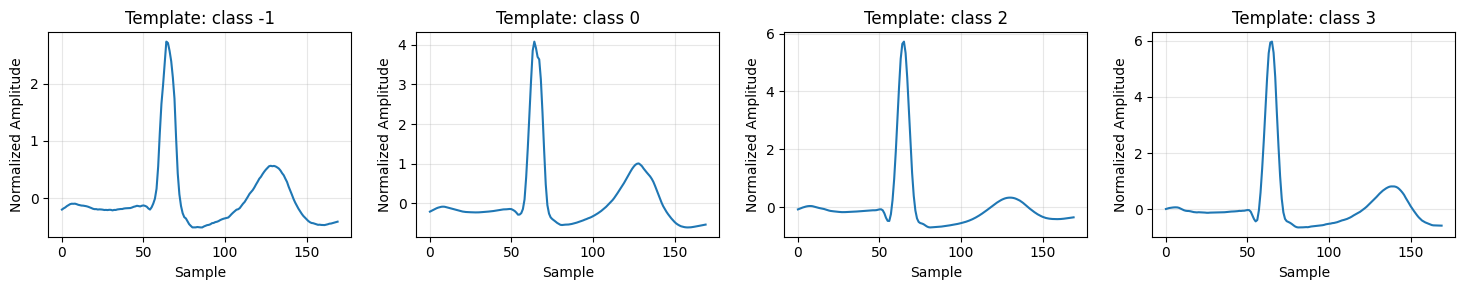


=== Loading Label-Free Beat Clusters ===


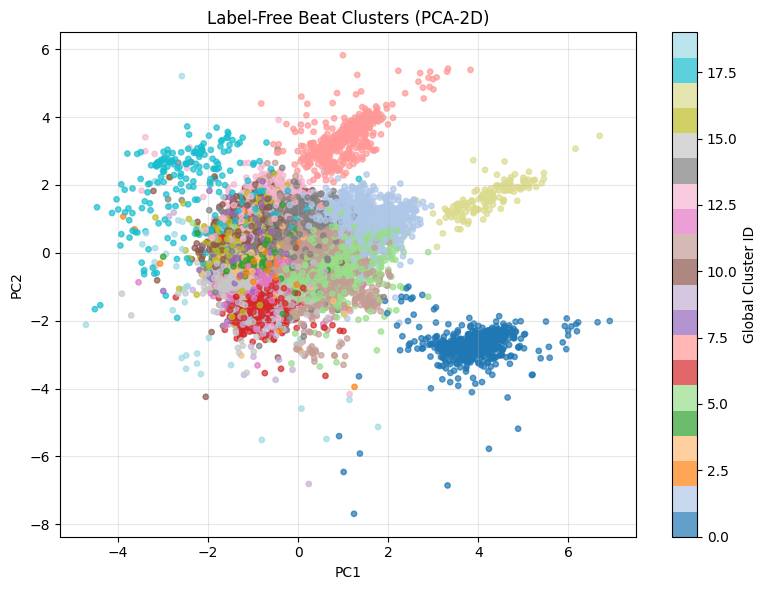

Showing top 20 prototype keys from: /content/ecg_preprocessed
key=prototype_11   size=5141  dominant_label=2   mix=2:3090;0:1893;-1:158 wave_shape=(170,)
key=prototype_5    size=2277  dominant_label=0   mix=0:1639;2:462;-1:153 wave_shape=(170,)
key=prototype_1    size=1563  dominant_label=0   mix=0:1221;2:174;3:112 wave_shape=(170,)
key=prototype_14   size=1250  dominant_label=0   mix=0:994;-1:132;2:124 wave_shape=(170,)
key=prototype_12   size=1211  dominant_label=0   mix=0:1127;-1:42;2:42 wave_shape=(170,)
key=prototype_4    size=1194  dominant_label=0   mix=0:1113;2:48;-1:33 wave_shape=(170,)
key=prototype_3    size=1193  dominant_label=0   mix=0:1123;-1:39;2:31 wave_shape=(170,)
key=prototype_8    size=768   dominant_label=0   mix=0:716;2:28;-1:24 wave_shape=(170,)
key=prototype_15   size=748   dominant_label=0   mix=0:451;2:226;-1:71 wave_shape=(170,)
key=prototype_2    size=740   dominant_label=0   mix=0:690;-1:28;2:22 wave_shape=(170,)
key=prototype_16   size=688   dominant_labe

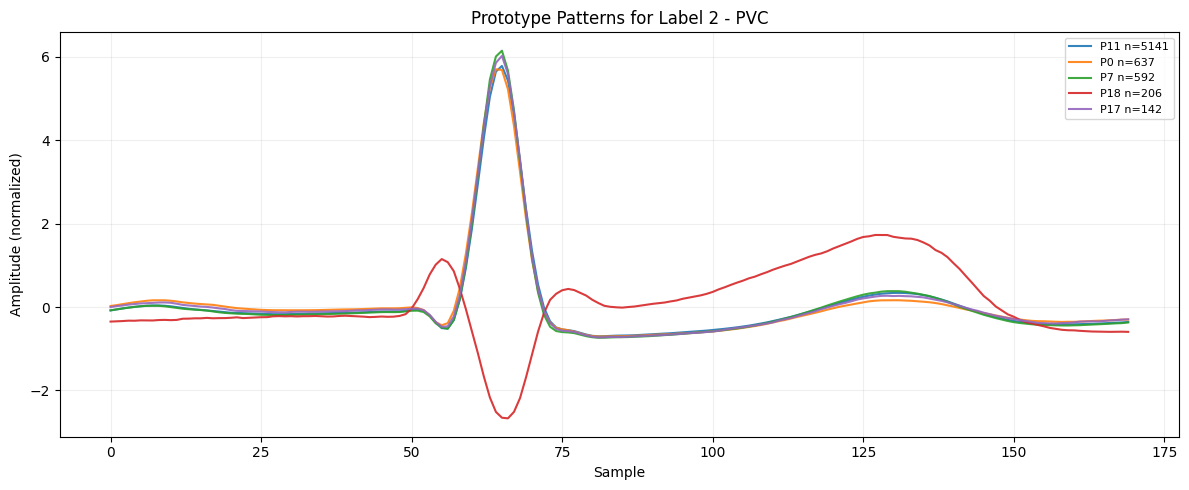

In [10]:
# 1) Point to the exact file location in Colab/Drive
SCRIPT_PATH = "/content/drive/MyDrive/HeartcareAI/Models/colab_ecg_preprocess.py"  # change if needed

# 2) Add its folder to path (This line is kept for completeness if future imports are needed from this path, though not strictly required for this specific fix)
import sys, os
sys.path.append(os.path.dirname(SCRIPT_PATH))

# 3) Remove import statement, as functions are already in global scope after executing cell 4pi6KcEEpaya
# from colab_ecg_preprocess import (
#     visualize_preprocessed_data,
#     inspect_prototype_keys,
#     plot_label_prototypes,
# )

OUT_DIR = "/content/ecg_preprocessed"

visualize_preprocessed_data(OUT_DIR)
inspect_prototype_keys(OUT_DIR, top_n=20)
plot_label_prototypes(OUT_DIR, label_id=2)

In [11]:
import pandas as pd
proto = pd.read_csv("/content/ecg_preprocessed/prototype_library.csv")
print(proto.groupby("dominant_label").size().sort_index())


dominant_label
-1     1
 0    14
 2     5
dtype: int64


In [12]:
# simple purity from label_mix_top3
def purity(mix):
    parts = [p.split(":") for p in str(mix).split(";")]
    counts = [int(c) for _, c in parts if c.isdigit()]
    return max(counts) / sum(counts) if counts else 0

proto["purity"] = proto["label_mix_top3"].apply(purity)
print(proto[proto["dominant_label"] == 2][["prototype_id","size","label_mix_top3","purity"]].sort_values("size", ascending=False))


    prototype_id  size        label_mix_top3    purity
0             11  5141  2:3090;0:1893;-1:158  0.601050
12             0   637      2:605;-1:18;0:14  0.949765
13             7   592       2:572;0:13;-1:6  0.967851
17            18   206       2:174;-1:29;0:3  0.844660
18            17   142        2:136;0:4;-1:2  0.957746


### Upcoming: Version 4

## Training

### Version 1

In [14]:
from __future__ import annotations

import argparse
import json
from pathlib import Path
from typing import List
import sys

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


class ECGContextDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = torch.tensor(x, dtype=torch.float32)  # (N, W, L)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class ECGContextNet(nn.Module):
    """
    CNN over each beat + BiLSTM across consecutive beats in window.
    Input: (batch, window, beat_len)
    """
    def __init__(self, num_classes: int, beat_len: int):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=7, padding=3),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(24, 48, kernel_size=5, padding=2),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(48, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=96,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.head = nn.Sequential(
            nn.Linear(192, 96),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(96, num_classes),
        )

    def forward(self, x):
        # x: (B, W, L)
        b, w, l = x.shape
        x = x.reshape(b * w, 1, l)
        f = self.cnn(x).squeeze(-1)      # (B*W, 64)
        f = f.reshape(b, w, 64)          # (B, W, 64)
        o, _ = self.lstm(f)              # (B, W, 192)
        center = o[:, w // 2, :]         # center beat context representation
        return self.head(center)


def load_npz_dirs(data_dirs: List[str]):
    xs, ys = [], []
    for d in data_dirs:
        p = Path(d) / "context_windows.npz"
        if not p.exists():
            continue
        data = np.load(p)
        x = data["X"].astype(np.float32)
        y = data["y"].astype(np.int64)
        valid = y >= 0  # ignore noise class if already set as -1
        xs.append(x[valid])
        ys.append(y[valid])
    if not xs:
        raise RuntimeError("No context_windows.npz found in provided --data_dirs")
    x = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)
    # remap to 0..K-1
    uniq = sorted(np.unique(y).tolist())
    remap = {old: i for i, old in enumerate(uniq)}
    y_new = np.array([remap[int(v)] for v in y], dtype=np.int64)
    return x, y_new, uniq


def train(args):
    x, y, original_labels = load_npz_dirs(args.data_dirs)
    beat_len = x.shape[2]
    num_classes = len(np.unique(y))

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    train_ds = ECGContextDataset(x_train, y_train)
    val_ds = ECGContextDataset(x_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ECGContextNet(num_classes=num_classes, beat_len=beat_len).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    best_val = 0.0
    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    best_path = out_dir / "best_context_model.pt"

    for epoch in range(1, args.epochs + 1):
        model.train()
        tr_loss, tr_ok, tr_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * xb.size(0)
            tr_ok += (logits.argmax(1) == yb).sum().item()
            tr_n += xb.size(0)

        model.eval()
        va_ok, va_n = 0, 0
        all_p, all_t = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                pred = logits.argmax(1)
                va_ok += (pred == yb).sum().item()
                va_n += xb.size(0)
                all_p.extend(pred.cpu().numpy().tolist())
                all_t.extend(yb.cpu().numpy().tolist())

        tr_acc = tr_ok / max(1, tr_n)
        va_acc = va_ok / max(1, va_n)
        print(f"Epoch {epoch:02d} | loss {tr_loss/max(1,tr_n):.4f} | train {tr_acc:.4f} | val {va_acc:.4f}")
        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)

    report = classification_report(all_t, all_p, output_dict=True)
    summary = {
        "best_val_acc": float(best_val),
        "num_samples": int(len(y)),
        "num_classes": int(num_classes),
        "original_label_values": original_labels,
        "model_path": str(best_path),
        "classification_report": report,
    }
    (out_dir / "training_summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print("Training complete.")
    print(json.dumps({k: v for k, v in summary.items() if k != "classification_report"}, indent=2))


def parse_args():
    p = argparse.ArgumentParser(description="Train ECG context model from preprocessed outputs")
    p.add_argument("--data_dirs", nargs='+', required=True, help="One or more preprocessing output dirs")
    p.add_argument("--epochs", type=int, default=20)
    p.add_argument("--batch_size", type=int, default=128)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--out_dir", required=True)
    return p.parse_args()


if __name__ == "__main__":
    # Supports both styles:
    # 1) CLI: python colab_ecg_train.py --data_dirs ... --out_dir ...
    # 2) Direct notebook run with no CLI args (uses editable defaults below)
    cli_has_required = ("--data_dirs" in sys.argv) and ("--out_dir" in sys.argv)
    if cli_has_required:
        train(parse_args())
    else:
        class Args:
            def __init__(self):
                self.data_dirs = ["/content/ecg_preprocessed"]
                self.out_dir = "/content/ecg_trained"
                self.epochs = 20
                self.batch_size = 128
                self.lr = 1e-3

        train(Args())

Epoch 01 | loss 0.5211 | train 0.7815 | val 0.8781
Epoch 02 | loss 0.3641 | train 0.8717 | val 0.8839
Epoch 03 | loss 0.3436 | train 0.8840 | val 0.7969
Epoch 04 | loss 0.3353 | train 0.8856 | val 0.8211
Epoch 05 | loss 0.3192 | train 0.8887 | val 0.8362
Epoch 06 | loss 0.3081 | train 0.8952 | val 0.8898
Epoch 07 | loss 0.3022 | train 0.8957 | val 0.8961
Epoch 08 | loss 0.3037 | train 0.8944 | val 0.8885
Epoch 09 | loss 0.3053 | train 0.8944 | val 0.8513
Epoch 10 | loss 0.3016 | train 0.8967 | val 0.8826
Epoch 11 | loss 0.2955 | train 0.8974 | val 0.8812
Epoch 12 | loss 0.2940 | train 0.8990 | val 0.8987
Epoch 13 | loss 0.2895 | train 0.8987 | val 0.8987
Epoch 14 | loss 0.2834 | train 0.9015 | val 0.8943
Epoch 15 | loss 0.2816 | train 0.9002 | val 0.8974
Epoch 16 | loss 0.2829 | train 0.8984 | val 0.8930
Epoch 17 | loss 0.2777 | train 0.9012 | val 0.8779
Epoch 18 | loss 0.2774 | train 0.9018 | val 0.8927
Epoch 19 | loss 0.2725 | train 0.9007 | val 0.8898
Epoch 20 | loss 0.2740 | train 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Updated: Version 2

In [15]:
"""
ECG training V2 (Colab): morphology + context + prototype similarity + noise gate.

BLOCK 1 (Install):
    !pip install -q numpy pandas scikit-learn torch

BLOCK 2 (Train with CLI):
    !python colab_ecg_train_v2.py \
      --data_dirs /content/ecg_preprocessed \
      --out_dir /content/ecg_trained_v2 \
      --epochs 25 \
      --batch_size 128

BLOCK 3 (Notebook-safe direct run):
    # Run file directly in notebook cell; __main__ defaults will be used.
"""

from __future__ import annotations

import argparse
import json
import math
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


# =========================
# BLOCK A: Data Utilities
# =========================
def _mix_purity(label_mix_top3: str) -> float:
    # format like "2:3090;0:1893;-1:158"
    if not isinstance(label_mix_top3, str) or ":" not in label_mix_top3:
        return 0.0
    pairs = []
    for part in label_mix_top3.split(";"):
        part = part.strip()
        if ":" not in part:
            continue
        a, b = part.split(":", 1)
        try:
            pairs.append((int(a), int(b)))
        except ValueError:
            continue
    if not pairs:
        return 0.0
    counts = [c for _, c in pairs]
    return float(max(counts)) / max(1.0, float(sum(counts)))


def load_prototype_bank(
    data_dirs: List[str],
    min_proto_size: int,
    min_proto_purity: float,
    max_prototypes: int,
) -> Tuple[np.ndarray, np.ndarray]:
    waves_all = []
    labels_all = []

    for d in data_dirs:
        dpath = Path(d)
        csv_path = dpath / "prototype_library.csv"
        npz_path = dpath / "prototype_library_waves.npz"
        if not (csv_path.exists() and npz_path.exists()):
            continue

        df = pd.read_csv(csv_path)
        waves = np.load(npz_path)
        if "prototype_id" not in df.columns:
            continue

        for _, r in df.iterrows():
            size = int(r.get("size", 0))
            purity = _mix_purity(str(r.get("label_mix_top3", "")))
            if size < min_proto_size or purity < min_proto_purity:
                continue
            pid = int(r["prototype_id"])
            key = f"prototype_{pid}"
            if key not in waves.files:
                continue
            w = waves[key].astype(np.float32)
            lbl = int(r.get("dominant_label", -1))
            waves_all.append(w)
            labels_all.append(lbl)

    if not waves_all:
        return np.empty((0, 0), dtype=np.float32), np.empty((0,), dtype=np.int64)

    # keep largest subset if too many
    waves_np = np.asarray(waves_all, dtype=np.float32)
    labels_np = np.asarray(labels_all, dtype=np.int64)
    if len(waves_np) > max_prototypes:
        idx = np.arange(len(waves_np))
        np.random.seed(42)
        np.random.shuffle(idx)
        idx = idx[:max_prototypes]
        waves_np = waves_np[idx]
        labels_np = labels_np[idx]
    return waves_np, labels_np


def cosine_proto_features(
    center_beats: np.ndarray,
    proto_waves: np.ndarray,
    proto_labels: np.ndarray,
    top_k_sim: int = 8,
) -> np.ndarray:
    """
    Build prototype feature vector:
      [top-k cosine similarities] + [max similarity per prototype label]
    """
    n = len(center_beats)
    if proto_waves.size == 0:
        return np.zeros((n, top_k_sim), dtype=np.float32)

    x = center_beats.astype(np.float32)
    p = proto_waves.astype(np.float32)

    x = x / (np.linalg.norm(x, axis=1, keepdims=True) + 1e-8)
    p = p / (np.linalg.norm(p, axis=1, keepdims=True) + 1e-8)

    sims = x @ p.T  # (N, P)
    k = min(top_k_sim, sims.shape[1])
    topk = -np.sort(-sims, axis=1)[:, :k]

    uniq_labels = sorted(np.unique(proto_labels).tolist())
    label_max = []
    for lbl in uniq_labels:
        idx = np.where(proto_labels == lbl)[0]
        if idx.size == 0:
            label_max.append(np.zeros((n, 1), dtype=np.float32))
        else:
            label_max.append(np.max(sims[:, idx], axis=1, keepdims=True).astype(np.float32))
    label_max_np = np.concatenate(label_max, axis=1) if label_max else np.zeros((n, 0), dtype=np.float32)
    return np.concatenate([topk.astype(np.float32), label_max_np], axis=1).astype(np.float32)


def load_training_data(
    data_dirs: List[str],
    min_proto_size: int,
    min_proto_purity: float,
    max_prototypes: int,
    top_k_sim: int,
):
    xs, ys = [], []
    for d in data_dirs:
        p = Path(d) / "context_windows.npz"
        if not p.exists():
            continue
        npz = np.load(p)
        xs.append(npz["X"].astype(np.float32))  # (N, W, L)
        ys.append(npz["y"].astype(np.int64))    # raw label values, may include -1
    if not xs:
        raise RuntimeError("No context_windows.npz found in --data_dirs")

    X = np.concatenate(xs, axis=0)
    y_raw = np.concatenate(ys, axis=0)
    center = X[:, X.shape[1] // 2, :]

    proto_waves, proto_labels = load_prototype_bank(
        data_dirs=data_dirs,
        min_proto_size=min_proto_size,
        min_proto_purity=min_proto_purity,
        max_prototypes=max_prototypes,
    )
    X_proto = cosine_proto_features(center, proto_waves, proto_labels, top_k_sim=top_k_sim)

    # class labels only for non-noise
    valid_class = y_raw >= 0
    uniq_cls = sorted(np.unique(y_raw[valid_class]).tolist()) if np.any(valid_class) else []
    remap = {old: i for i, old in enumerate(uniq_cls)}
    y_class = np.full_like(y_raw, fill_value=-1, dtype=np.int64)
    for old, new in remap.items():
        y_class[y_raw == old] = new

    # noise gate target
    y_gate = (y_raw < 0).astype(np.float32)

    meta = {
        "raw_class_values": uniq_cls,
        "num_prototypes": int(len(proto_waves)),
        "proto_feature_dim": int(X_proto.shape[1]),
    }
    return X, X_proto, y_class, y_gate, meta


# =========================
# BLOCK B: Model
# =========================
class ECGHybridDataset(Dataset):
    def __init__(self, x_ctx: np.ndarray, x_proto: np.ndarray, y_cls: np.ndarray, y_gate: np.ndarray):
        self.x_ctx = torch.tensor(x_ctx, dtype=torch.float32)
        self.x_proto = torch.tensor(x_proto, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls, dtype=torch.long)
        self.y_gate = torch.tensor(y_gate, dtype=torch.float32)

    def __len__(self):
        return len(self.y_cls)

    def __getitem__(self, idx):
        return self.x_ctx[idx], self.x_proto[idx], self.y_cls[idx], self.y_gate[idx]


class ECGHybridNet(nn.Module):
    """
    3-branch model:
      1) beat morphology feature
      2) temporal context feature
      3) prototype similarity feature
    outputs:
      - class logits
      - noise gate logit
    """
    def __init__(self, num_classes: int, proto_dim: int):
        super().__init__()
        self.beat_encoder = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=7, padding=3),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(24, 48, kernel_size=5, padding=2),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(48, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.context_lstm = nn.LSTM(
            input_size=64,
            hidden_size=96,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.proto_mlp = nn.Sequential(
            nn.Linear(max(1, proto_dim), 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.fusion = nn.Sequential(
            nn.Linear(64 + 192 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 96),
            nn.ReLU(),
        )
        self.class_head = nn.Linear(96, num_classes)
        self.gate_head = nn.Linear(96, 1)

    def forward(self, x_ctx, x_proto):
        # x_ctx: (B, W, L), x_proto: (B, D)
        b, w, l = x_ctx.shape
        x = x_ctx.reshape(b * w, 1, l)
        beat_feat = self.beat_encoder(x).squeeze(-1)   # (B*W,64)
        beat_feat = beat_feat.reshape(b, w, 64)        # (B,W,64)

        morph_feat = beat_feat[:, w // 2, :]           # center beat morphology
        ctx_out, _ = self.context_lstm(beat_feat)      # (B,W,192)
        ctx_feat = ctx_out[:, w // 2, :]               # center with temporal context

        proto_feat = self.proto_mlp(x_proto)
        fused = self.fusion(torch.cat([morph_feat, ctx_feat, proto_feat], dim=1))
        class_logits = self.class_head(fused)
        gate_logit = self.gate_head(fused).squeeze(1)
        return class_logits, gate_logit


# =========================
# BLOCK C: Train / Eval
# =========================
def split_data(X, XP, YC, YG, test_size=0.2):
    idx = np.arange(len(YC))
    # stratify by raw behavior proxy: class id where valid else special id
    strat = YC.copy()
    strat[strat < 0] = np.max(strat) + 1 if np.any(strat >= 0) else 0
    tr_idx, va_idx = train_test_split(idx, test_size=test_size, random_state=42, stratify=strat)
    return (
        X[tr_idx], XP[tr_idx], YC[tr_idx], YG[tr_idx],
        X[va_idx], XP[va_idx], YC[va_idx], YG[va_idx],
    )


def train_v2(args):
    X, XP, YC, YG, meta = load_training_data(
        data_dirs=args.data_dirs,
        min_proto_size=args.min_proto_size,
        min_proto_purity=args.min_proto_purity,
        max_prototypes=args.max_prototypes,
        top_k_sim=args.top_k_sim,
    )
    num_classes = int(np.max(YC) + 1) if np.any(YC >= 0) else 1

    Xtr, XPtr, YCtr, YGtr, Xva, XPva, YCva, YGva = split_data(X, XP, YC, YG, test_size=args.val_split)
    tr_ds = ECGHybridDataset(Xtr, XPtr, YCtr, YGtr)
    va_ds = ECGHybridDataset(Xva, XPva, YCva, YGva)
    tr_loader = DataLoader(tr_ds, batch_size=args.batch_size, shuffle=True, num_workers=0)
    va_loader = DataLoader(va_ds, batch_size=args.batch_size, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ECGHybridNet(num_classes=num_classes, proto_dim=XP.shape[1]).to(device)
    cls_loss_fn = nn.CrossEntropyLoss()
    gate_loss_fn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr=args.lr)

    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    best_path = out_dir / "best_hybrid_v2.pt"
    best_val = 0.0

    for epoch in range(1, args.epochs + 1):
        model.train()
        tr_loss, tr_cls_ok, tr_cls_n = 0.0, 0, 0
        tr_gate_ok, tr_gate_n = 0, 0

        for x_ctx, x_proto, y_cls, y_gate in tr_loader:
            x_ctx = x_ctx.to(device)
            x_proto = x_proto.to(device)
            y_cls = y_cls.to(device)
            y_gate = y_gate.to(device)

            optim.zero_grad()
            cls_logits, gate_logit = model(x_ctx, x_proto)

            valid = y_cls >= 0
            if torch.any(valid):
                l_cls = cls_loss_fn(cls_logits[valid], y_cls[valid])
            else:
                l_cls = torch.tensor(0.0, device=device)
            l_gate = gate_loss_fn(gate_logit, y_gate)
            loss = l_cls + args.gate_loss_weight * l_gate
            loss.backward()
            optim.step()

            tr_loss += float(loss.item()) * x_ctx.size(0)
            if torch.any(valid):
                pred = cls_logits.argmax(1)
                tr_cls_ok += int((pred[valid] == y_cls[valid]).sum().item())
                tr_cls_n += int(valid.sum().item())
            gate_pred = (torch.sigmoid(gate_logit) >= 0.5).float()
            tr_gate_ok += int((gate_pred == y_gate).sum().item())
            tr_gate_n += int(y_gate.numel())

        # validation
        model.eval()
        va_cls_ok, va_cls_n = 0, 0
        va_gate_ok, va_gate_n = 0, 0
        all_p, all_t = [], []
        with torch.no_grad():
            for x_ctx, x_proto, y_cls, y_gate in va_loader:
                x_ctx = x_ctx.to(device)
                x_proto = x_proto.to(device)
                y_cls = y_cls.to(device)
                y_gate = y_gate.to(device)

                cls_logits, gate_logit = model(x_ctx, x_proto)
                valid = y_cls >= 0
                if torch.any(valid):
                    pred = cls_logits.argmax(1)
                    va_cls_ok += int((pred[valid] == y_cls[valid]).sum().item())
                    va_cls_n += int(valid.sum().item())
                    all_p.extend(pred[valid].cpu().numpy().tolist())
                    all_t.extend(y_cls[valid].cpu().numpy().tolist())
                gate_pred = (torch.sigmoid(gate_logit) >= 0.5).float()
                va_gate_ok += int((gate_pred == y_gate).sum().item())
                va_gate_n += int(y_gate.numel())

        tr_cls_acc = tr_cls_ok / max(1, tr_cls_n)
        va_cls_acc = va_cls_ok / max(1, va_cls_n)
        tr_gate_acc = tr_gate_ok / max(1, tr_gate_n)
        va_gate_acc = va_gate_ok / max(1, va_gate_n)
        print(
            f"Epoch {epoch:02d} | loss {tr_loss/max(1,len(tr_ds)):.4f} "
            f"| cls(train/val) {tr_cls_acc:.4f}/{va_cls_acc:.4f} "
            f"| gate(train/val) {tr_gate_acc:.4f}/{va_gate_acc:.4f}"
        )

        # select by class accuracy primarily; small tie-break on gate
        score = va_cls_acc + 0.05 * va_gate_acc
        if score > best_val:
            best_val = score
            torch.save(model.state_dict(), best_path)

    if all_t and all_p:
        report = classification_report(all_t, all_p, output_dict=True)
    else:
        report = {}

    summary = {
        "best_score": float(best_val),
        "num_samples": int(len(YC)),
        "num_classes_non_noise": int(num_classes),
        "raw_class_values": meta["raw_class_values"],
        "num_prototypes_used": meta["num_prototypes"],
        "proto_feature_dim": meta["proto_feature_dim"],
        "model_path": str(best_path),
        "classification_report_non_noise": report,
    }
    (out_dir / "training_summary_v2.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print("Training V2 complete.")
    print(json.dumps({k: v for k, v in summary.items() if "report" not in k}, indent=2))


# =========================
# BLOCK D: Runtime
# =========================
def parse_args():
    p = argparse.ArgumentParser(description="Hybrid ECG training V2 (morphology + context + prototypes + gate)")
    p.add_argument("--data_dirs", nargs="+", required=True, help="One or more preprocess output dirs")
    p.add_argument("--out_dir", required=True)
    p.add_argument("--epochs", type=int, default=25)
    p.add_argument("--batch_size", type=int, default=128)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--val_split", type=float, default=0.2)
    p.add_argument("--gate_loss_weight", type=float, default=0.5)
    p.add_argument("--min_proto_size", type=int, default=120)
    p.add_argument("--min_proto_purity", type=float, default=0.70)
    p.add_argument("--max_prototypes", type=int, default=256)
    p.add_argument("--top_k_sim", type=int, default=8)
    return p.parse_args()


if __name__ == "__main__":
    cli_has_required = ("--data_dirs" in sys.argv) and ("--out_dir" in sys.argv)
    if cli_has_required:
        train_v2(parse_args())
    else:
        class Args:
            def __init__(self):
                self.data_dirs = ["/content/ecg_preprocessed"]
                self.out_dir = "/content/ecg_trained_v2"
                self.epochs = 25
                self.batch_size = 128
                self.lr = 1e-3
                self.val_split = 0.2
                self.gate_loss_weight = 0.5
                self.min_proto_size = 120
                self.min_proto_purity = 0.70
                self.max_prototypes = 256
                self.top_k_sim = 8

        train_v2(Args())

Epoch 01 | loss 0.7145 | cls(train/val) 0.7340/0.7547 | gate(train/val) 0.9464/0.9465
Epoch 02 | loss 0.4772 | cls(train/val) 0.8632/0.8724 | gate(train/val) 0.9476/0.9527
Epoch 03 | loss 0.4363 | cls(train/val) 0.8813/0.8870 | gate(train/val) 0.9519/0.9534
Epoch 04 | loss 0.4189 | cls(train/val) 0.8845/0.8635 | gate(train/val) 0.9529/0.9556
Epoch 05 | loss 0.3928 | cls(train/val) 0.8919/0.8727 | gate(train/val) 0.9540/0.9554
Epoch 06 | loss 0.3778 | cls(train/val) 0.8945/0.8898 | gate(train/val) 0.9545/0.9559
Epoch 07 | loss 0.3707 | cls(train/val) 0.8961/0.8977 | gate(train/val) 0.9545/0.9537
Epoch 08 | loss 0.3699 | cls(train/val) 0.8954/0.8826 | gate(train/val) 0.9542/0.9574
Epoch 09 | loss 0.3648 | cls(train/val) 0.8956/0.8906 | gate(train/val) 0.9554/0.9574
Epoch 10 | loss 0.3585 | cls(train/val) 0.8971/0.8904 | gate(train/val) 0.9559/0.9416
Epoch 11 | loss 0.3477 | cls(train/val) 0.8985/0.8917 | gate(train/val) 0.9569/0.9581
Epoch 12 | loss 0.3421 | cls(train/val) 0.8988/0.8964 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Updated: Version 3

In [22]:
"""
ECG training V2 (Colab): morphology + context + prototype similarity + noise gate.

BLOCK 1 (Install):
    !pip install -q numpy pandas scikit-learn torch

BLOCK 2 (Train with CLI):
    !python colab_ecg_train_v2.py \
      --data_dirs /content/ecg_preprocessed \
      --out_dir /content/ecg_trained_v2 \
      --epochs 25 \
      --batch_size 128

BLOCK 3 (Notebook-safe direct run):
    # Run file directly in notebook cell; __main__ defaults will be used.
"""

from __future__ import annotations

import argparse
import json
import math
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


# =========================
# BLOCK A: Data Utilities
# =========================
def _mix_purity(label_mix_top3: str) -> float:
    # format like "2:3090;0:1893;-1:158"
    if not isinstance(label_mix_top3, str) or ":" not in label_mix_top3:
        return 0.0
    pairs = []
    for part in label_mix_top3.split(";"):
        part = part.strip()
        if ":" not in part:
            continue
        a, b = part.split(":", 1)
        try:
            pairs.append((int(a), int(b)))
        except ValueError:
            continue
    if not pairs:
        return 0.0
    counts = [c for _, c in pairs]
    return float(max(counts)) / max(1.0, float(sum(counts)))


def load_prototype_bank(
    data_dirs: List[str],
    min_proto_size: int,
    min_proto_purity: float,
    max_prototypes: int,
) -> Tuple[np.ndarray, np.ndarray]:
    waves_all = []
    labels_all = []

    for d in data_dirs:
        dpath = Path(d)
        csv_path = dpath / "prototype_library.csv"
        npz_path = dpath / "prototype_library_waves.npz"
        if not (csv_path.exists() and npz_path.exists()):
            continue

        df = pd.read_csv(csv_path)
        waves = np.load(npz_path)
        if "prototype_id" not in df.columns:
            continue

        for _, r in df.iterrows():
            size = int(r.get("size", 0))
            purity = _mix_purity(str(r.get("label_mix_top3", "")))
            if size < min_proto_size or purity < min_proto_purity:
                continue
            pid = int(r["prototype_id"])
            key = f"prototype_{pid}"
            if key not in waves.files:
                continue
            w = waves[key].astype(np.float32)
            lbl = int(r.get("dominant_label", -1))
            waves_all.append(w)
            labels_all.append(lbl)

    if not waves_all:
        return np.empty((0, 0), dtype=np.float32), np.empty((0,), dtype=np.int64)

    # keep largest subset if too many
    waves_np = np.asarray(waves_all, dtype=np.float32)
    labels_np = np.asarray(labels_all, dtype=np.int64)
    if len(waves_np) > max_prototypes:
        idx = np.arange(len(waves_np))
        np.random.seed(42)
        np.random.shuffle(idx)
        idx = idx[:max_prototypes]
        waves_np = waves_np[idx]
        labels_np = labels_np[idx]
    return waves_np, labels_np


def cosine_proto_features(
    center_beats: np.ndarray,
    proto_waves: np.ndarray,
    proto_labels: np.ndarray,
    top_k_sim: int = 8,
) -> np.ndarray:
    """
    Build prototype feature vector:
      [top-k cosine similarities] + [max similarity per prototype label]
    """
    n = len(center_beats)
    if proto_waves.size == 0:
        return np.zeros((n, top_k_sim), dtype=np.float32)

    x = center_beats.astype(np.float32)
    p = proto_waves.astype(np.float32)

    x = x / (np.linalg.norm(x, axis=1, keepdims=True) + 1e-8)
    p = p / (np.linalg.norm(p, axis=1, keepdims=True) + 1e-8)

    sims = x @ p.T  # (N, P)
    k = min(top_k_sim, sims.shape[1])
    topk = -np.sort(-sims, axis=1)[:, :k]

    uniq_labels = sorted(np.unique(proto_labels).tolist())
    label_max = []
    for lbl in uniq_labels:
        idx = np.where(proto_labels == lbl)[0]
        if idx.size == 0:
            label_max.append(np.zeros((n, 1), dtype=np.float32))
        else:
            label_max.append(np.max(sims[:, idx], axis=1, keepdims=True).astype(np.float32))
    label_max_np = np.concatenate(label_max, axis=1) if label_max else np.zeros((n, 0), dtype=np.float32)
    return np.concatenate([topk.astype(np.float32), label_max_np], axis=1).astype(np.float32)


def load_training_data(
    data_dirs: List[str],
    min_proto_size: int,
    min_proto_purity: float,
    max_prototypes: int,
    top_k_sim: int,
):
    xs, ys = [], []
    for d in data_dirs:
        p = Path(d) / "context_windows.npz"
        if not p.exists():
            continue
        npz = np.load(p)
        xs.append(npz["X"].astype(np.float32))  # (N, W, L)
        ys.append(npz["y"].astype(np.int64))    # raw label values, may include -1
    if not xs:
        raise RuntimeError("No context_windows.npz found in --data_dirs")

    X = np.concatenate(xs, axis=0)
    y_raw = np.concatenate(ys, axis=0)
    center = X[:, X.shape[1] // 2, :]

    proto_waves, proto_labels = load_prototype_bank(
        data_dirs=data_dirs,
        min_proto_size=min_proto_size,
        min_proto_purity=min_proto_purity,
        max_prototypes=max_prototypes,
    )
    X_proto = cosine_proto_features(center, proto_waves, proto_labels, top_k_sim=top_k_sim)

    # class labels only for non-noise
    valid_class = y_raw >= 0
    uniq_cls = sorted(np.unique(y_raw[valid_class]).tolist()) if np.any(valid_class) else []
    remap = {old: i for i, old in enumerate(uniq_cls)}
    y_class = np.full_like(y_raw, fill_value=-1, dtype=np.int64)
    for old, new in remap.items():
        y_class[y_raw == old] = new

    # noise gate target
    y_gate = (y_raw < 0).astype(np.float32)

    meta = {
        "raw_class_values": uniq_cls,
        "num_prototypes": int(len(proto_waves)),
        "proto_feature_dim": int(X_proto.shape[1]),
    }
    return X, X_proto, y_class, y_gate, meta


# =========================
# BLOCK B: Model
# =========================
class ECGHybridDataset(Dataset):
    def __init__(self, x_ctx: np.ndarray, x_proto: np.ndarray, y_cls: np.ndarray, y_gate: np.ndarray):
        self.x_ctx = torch.tensor(x_ctx, dtype=torch.float32)
        self.x_proto = torch.tensor(x_proto, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls, dtype=torch.long)
        self.y_gate = torch.tensor(y_gate, dtype=torch.float32)

    def __len__(self):
        return len(self.y_cls)

    def __getitem__(self, idx):
        return self.x_ctx[idx], self.x_proto[idx], self.y_cls[idx], self.y_gate[idx]


class ECGHybridNet(nn.Module):
    """
    3-branch model:
      1) beat morphology feature
      2) temporal context feature
      3) prototype similarity feature
    outputs:
      - class logits
      - noise gate logit
    """
    def __init__(self, num_classes: int, proto_dim: int):
        super().__init__()
        self.beat_encoder = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=7, padding=3),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(24, 48, kernel_size=5, padding=2),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(48, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.context_lstm = nn.LSTM(
            input_size=64,
            hidden_size=96,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.proto_mlp = nn.Sequential(
            nn.Linear(max(1, proto_dim), 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.fusion = nn.Sequential(
            nn.Linear(64 + 192 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 96),
            nn.ReLU(),
        )
        self.class_head = nn.Linear(96, num_classes)
        self.gate_head = nn.Linear(96, 1)

    def forward(self, x_ctx, x_proto):
        # x_ctx: (B, W, L), x_proto: (B, D)
        b, w, l = x_ctx.shape
        x = x_ctx.reshape(b * w, 1, l)
        beat_feat = self.beat_encoder(x).squeeze(-1)   # (B*W,64)
        beat_feat = beat_feat.reshape(b, w, 64)        # (B,W,64)

        morph_feat = beat_feat[:, w // 2, :]           # center beat morphology
        ctx_out, _ = self.context_lstm(beat_feat)      # (B,W,192)
        ctx_feat = ctx_out[:, w // 2, :]               # center with temporal context

        proto_feat = self.proto_mlp(x_proto)
        fused = self.fusion(torch.cat([morph_feat, ctx_feat, proto_feat], dim=1))
        class_logits = self.class_head(fused)
        gate_logit = self.gate_head(fused).squeeze(1)
        return class_logits, gate_logit


# =========================
# BLOCK C: Train / Eval
# =========================
def split_data(X, XP, YC, YG, test_size=0.2):
    idx = np.arange(len(YC))
    # stratify by raw behavior proxy: class id where valid else special id
    strat = YC.copy()
    strat[strat < 0] = np.max(strat) + 1 if np.any(strat >= 0) else 0
    tr_idx, va_idx = train_test_split(idx, test_size=test_size, random_state=42, stratify=strat)
    return (
        X[tr_idx], XP[tr_idx], YC[tr_idx], YG[tr_idx],
        X[va_idx], XP[va_idx], YC[va_idx], YG[va_idx],
    )


def train_v2(args):
    X, XP, YC, YG, meta = load_training_data(
        data_dirs=args.data_dirs,
        min_proto_size=args.min_proto_size,
        min_proto_purity=args.min_proto_purity,
        max_prototypes=args.max_prototypes,
        top_k_sim=args.top_k_sim,
    )
    num_classes = int(np.max(YC) + 1) if np.any(YC >= 0) else 1

    Xtr, XPtr, YCtr, YGtr, Xva, XPva, YCva, YGva = split_data(X, XP, YC, YG, test_size=args.val_split)
    tr_ds = ECGHybridDataset(Xtr, XPtr, YCtr, YGtr)
    va_ds = ECGHybridDataset(Xva, XPva, YCva, YGva)
    tr_loader = DataLoader(tr_ds, batch_size=args.batch_size, shuffle=True, num_workers=0)
    va_loader = DataLoader(va_ds, batch_size=args.batch_size, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ECGHybridNet(num_classes=num_classes, proto_dim=XP.shape[1]).to(device)

    # Class imbalance handling for non-noise classes.
    if args.use_class_weights:
        valid_tr = YCtr >= 0
        counts = np.bincount(YCtr[valid_tr], minlength=num_classes).astype(np.float32)
        counts[counts == 0] = 1.0
        inv = 1.0 / counts
        w = inv / inv.sum() * num_classes
        class_w = torch.tensor(w, dtype=torch.float32, device=device)
        cls_loss_fn = nn.CrossEntropyLoss(weight=class_w)
    else:
        cls_loss_fn = nn.CrossEntropyLoss()

    gate_loss_fn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr=args.lr)

    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    best_path = out_dir / "best_hybrid_v2.pt"
    best_val = 0.0

    for epoch in range(1, args.epochs + 1):
        model.train()
        tr_loss, tr_cls_ok, tr_cls_n = 0.0, 0, 0
        tr_gate_ok, tr_gate_n = 0, 0

        for x_ctx, x_proto, y_cls, y_gate in tr_loader:
            x_ctx = x_ctx.to(device)
            x_proto = x_proto.to(device)
            y_cls = y_cls.to(device)
            y_gate = y_gate.to(device)

            optim.zero_grad()
            cls_logits, gate_logit = model(x_ctx, x_proto)

            valid = y_cls >= 0
            if torch.any(valid):
                l_cls = cls_loss_fn(cls_logits[valid], y_cls[valid])
            else:
                l_cls = torch.tensor(0.0, device=device)
            l_gate = gate_loss_fn(gate_logit, y_gate)
            loss = l_cls + args.gate_loss_weight * l_gate
            loss.backward()
            optim.step()

            tr_loss += float(loss.item()) * x_ctx.size(0)
            if torch.any(valid):
                pred = cls_logits.argmax(1)
                tr_cls_ok += int((pred[valid] == y_cls[valid]).sum().item())
                tr_cls_n += int(valid.sum().item())
            gate_pred = (torch.sigmoid(gate_logit) >= 0.5).float()
            tr_gate_ok += int((gate_pred == y_gate).sum().item())
            tr_gate_n += int(y_gate.numel())

        # validation
        model.eval()
        va_cls_ok, va_cls_n = 0, 0
        va_gate_ok, va_gate_n = 0, 0
        all_p, all_t = [], []
        with torch.no_grad():
            for x_ctx, x_proto, y_cls, y_gate in va_loader:
                x_ctx = x_ctx.to(device)
                x_proto = x_proto.to(device)
                y_cls = y_cls.to(device)
                y_gate = y_gate.to(device)

                cls_logits, gate_logit = model(x_ctx, x_proto)
                valid = y_cls >= 0
                if torch.any(valid):
                    pred = cls_logits.argmax(1)
                    va_cls_ok += int((pred[valid] == y_cls[valid]).sum().item())
                    va_cls_n += int(valid.sum().item())
                    all_p.extend(pred[valid].cpu().numpy().tolist())
                    all_t.extend(y_cls[valid].cpu().numpy().tolist())
                gate_pred = (torch.sigmoid(gate_logit) >= 0.5).float()
                va_gate_ok += int((gate_pred == y_gate).sum().item())
                va_gate_n += int(y_gate.numel())

        tr_cls_acc = tr_cls_ok / max(1, tr_cls_n)
        va_cls_acc = va_cls_ok / max(1, va_cls_n)
        tr_gate_acc = tr_gate_ok / max(1, tr_gate_n)
        va_gate_acc = va_gate_ok / max(1, va_gate_n)
        print(
            f"Epoch {epoch:02d} | loss {tr_loss/max(1,len(tr_ds)):.4f} "
            f"| cls(train/val) {tr_cls_acc:.4f}/{va_cls_acc:.4f} "
            f"| gate(train/val) {tr_gate_acc:.4f}/{va_gate_acc:.4f}"
        )

        # select by class accuracy primarily; small tie-break on gate
        score = va_cls_acc + 0.05 * va_gate_acc
        if score > best_val:
            best_val = score
            torch.save(model.state_dict(), best_path)

    if all_t and all_p:
        report = classification_report(all_t, all_p, output_dict=True, zero_division=0)
        cm = confusion_matrix(all_t, all_p).tolist()
    else:
        report = {}
        cm = []

    summary = {
        "best_score": float(best_val),
        "num_samples": int(len(YC)),
        "num_classes_non_noise": int(num_classes),
        "raw_class_values": meta["raw_class_values"],
        "num_prototypes_used": meta["num_prototypes"],
        "proto_feature_dim": meta["proto_feature_dim"],
        "model_path": str(best_path),
        "use_class_weights": bool(args.use_class_weights),
        "confusion_matrix_non_noise": cm,
        "classification_report_non_noise": report,
    }
    (out_dir / "training_summary_v2.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print("Training V2 complete.")
    print(json.dumps({k: v for k, v in summary.items() if "report" not in k}, indent=2))


# =========================
# BLOCK D: Runtime
# =========================
def parse_args():
    p = argparse.ArgumentParser(description="Hybrid ECG training V2 (morphology + context + prototypes + gate)")
    p.add_argument("--data_dirs", nargs="+", required=True, help="One or more preprocess output dirs")
    p.add_argument("--out_dir", required=True)
    p.add_argument("--epochs", type=int, default=25)
    p.add_argument("--batch_size", type=int, default=128)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--val_split", type=float, default=0.2)
    p.add_argument("--gate_loss_weight", type=float, default=0.5)
    p.add_argument("--min_proto_size", type=int, default=120)
    p.add_argument("--min_proto_purity", type=float, default=0.70)
    p.add_argument("--max_prototypes", type=int, default=256)
    p.add_argument("--top_k_sim", type=int, default=8)
    p.add_argument("--use_class_weights", type=int, default=1, help="1=enable inverse-frequency CE class weights")
    return p.parse_args()


if __name__ == "__main__":
    cli_has_required = ("--data_dirs" in sys.argv) and ("--out_dir" in sys.argv)
    if cli_has_required:
        train_v2(parse_args())
    else:
        class Args:
            def __init__(self):
                self.data_dirs = ["/content/ecg_preprocessed"]
                self.out_dir = "/content/ecg_trained_v2"
                self.epochs = 25
                self.batch_size = 128
                self.lr = 1e-3
                self.val_split = 0.2
                self.gate_loss_weight = 0.5
                self.min_proto_size = 120
                self.min_proto_purity = 0.70
                self.max_prototypes = 256
                self.top_k_sim = 8
                self.use_class_weights = 1

        train_v2(Args())


Epoch 01 | loss 1.1742 | cls(train/val) 0.6258/0.6497 | gate(train/val) 0.9464/0.9465
Epoch 02 | loss 0.9372 | cls(train/val) 0.6704/0.7453 | gate(train/val) 0.9464/0.9465
Epoch 03 | loss 0.7599 | cls(train/val) 0.6648/0.5896 | gate(train/val) 0.9468/0.9492
Epoch 04 | loss 0.7020 | cls(train/val) 0.6718/0.6255 | gate(train/val) 0.9492/0.9473
Epoch 05 | loss 0.6780 | cls(train/val) 0.6795/0.6560 | gate(train/val) 0.9518/0.9539
Epoch 06 | loss 0.6072 | cls(train/val) 0.7002/0.6500 | gate(train/val) 0.9530/0.9527
Epoch 07 | loss 0.5736 | cls(train/val) 0.7093/0.7089 | gate(train/val) 0.9537/0.9522
Epoch 08 | loss 0.5971 | cls(train/val) 0.7103/0.7247 | gate(train/val) 0.9551/0.9500
Epoch 09 | loss 0.5665 | cls(train/val) 0.7280/0.7312 | gate(train/val) 0.9534/0.9524
Epoch 10 | loss 0.5125 | cls(train/val) 0.7742/0.8010 | gate(train/val) 0.9546/0.9542
Epoch 11 | loss 0.4988 | cls(train/val) 0.7909/0.8187 | gate(train/val) 0.9553/0.9544
Epoch 12 | loss 0.4986 | cls(train/val) 0.7744/0.7352 

## New Pattern

In [17]:
from __future__ import annotations

import argparse
import json
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def main(args):
    pre = Path(args.preprocessed_dir)
    out = Path(args.out_dir)
    out.mkdir(parents=True, exist_ok=True)

    beats = np.load(pre / "beats.npy")
    feats = np.load(pre / "features.npy") if (pre / "features.npy").exists() else None
    if feats is None:
        raise RuntimeError("features.npy not found in preprocessed_dir.")

    # Ensure predictions_csv exists before trying to read it
    predictions_csv_path = Path(args.predictions_csv)
    if not predictions_csv_path.exists():
        print(f"Warning: predictions_csv not found at {predictions_csv_path}. Skipping new pattern detection.")
        summary = {"unknown_count": 0, "alerts": 0}
        (out / "new_pattern_summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
        print(json.dumps(summary, indent=2))
        return

    pred = pd.read_csv(predictions_csv_path)
    if "review_flag" not in pred.columns:
        raise RuntimeError("predictions_csv must contain review_flag column from predict_v2.py")

    unknown_idx = np.where(pred["review_flag"].values == 1)[0]
    if unknown_idx.size == 0:
        summary = {"unknown_count": 0, "alerts": 0}
        (out / "new_pattern_summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
        print(json.dumps(summary, indent=2))
        return

    u_feat = feats[unknown_idx]
    u_beat = beats[unknown_idx]

    k = max(2, min(args.max_clusters, int(np.sqrt(len(unknown_idx) / max(1, args.cluster_scale)))))
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    cid = model.fit_predict(u_feat)

    rows = []
    for c in sorted(np.unique(cid).tolist()):
        idx_local = np.where(cid == c)[0]
        idx_global = unknown_idx[idx_local]
        size = len(idx_local)
        centroid = np.median(u_beat[idx_local], axis=0)
        np.save(out / f"cluster_{c}_centroid.npy", centroid.astype(np.float32))
        rows.append(
            {
                "cluster_id": int(c),
                "size": int(size),
                "size_ratio": float(size / max(1, len(unknown_idx))),
                "example_beat_ids": ",".join(map(str, idx_global[:15].tolist())),
                "alert_flag": int(size >= args.min_alert_size),
            }
        )

    rep = pd.DataFrame(rows).sort_values("size", ascending=False)
    rep.to_csv(out / "new_pattern_clusters.csv", index=False)
    rep[rep["alert_flag"] == 1].to_csv(out / "new_pattern_alerts.csv", index=False)

    # PCA plot
    p2 = PCA(n_components=2, random_state=42).fit_transform(u_feat)
    plt.figure(figsize=(8, 6))
    plt.scatter(p2[:, 0], p2[:, 1], c=cid, cmap="tab20", s=10, alpha=0.75)
    plt.title("Unknown/Review Beat Clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(out / "unknown_clusters_pca2d.png", dpi=170)
    plt.close()

    # centroid gallery
    show = rep.head(min(args.max_plot_clusters, len(rep)))
    cols = 4
    rows_n = int(np.ceil(len(show) / cols))
    plt.figure(figsize=(4 * cols, 2.5 * rows_n))
    for i, (_, r) in enumerate(show.iterrows(), 1):
        c = int(r["cluster_id"])
        w = np.load(out / f"cluster_{c}_centroid.npy")
        ax = plt.subplot(rows_n, cols, i)
        ax.plot(w, linewidth=1.4)
        ax.set_title(f"C{c} n={int(r["size"])}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(out / "unknown_cluster_centroids.png", dpi=170)
    plt.close()

    summary = {
        "unknown_count": int(len(unknown_idx)),
        "clusters_found": int(len(rep)),
        "alerts": int((rep["alert_flag"] == 1).sum()),
        "min_alert_size": int(args.min_alert_size),
    }
    (out / "new_pattern_summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print(json.dumps(summary, indent=2))
    print(f"Saved alerts to: {out}")


def parse_args():
    p = argparse.ArgumentParser(description="Detect frequent unknown/new ECG patterns")
    p.add_argument("--preprocessed_dir", required=True)
    p.add_argument("--predictions_csv", required=True, help="beat_predictions_v2.csv from predict_v2.py")
    p.add_argument("--out_dir", required=True)
    p.add_argument("--min_alert_size", type=int, default=80)
    p.add_argument("--max_clusters", type=int, default=20)
    p.add_argument("--cluster_scale", type=int, default=40)
    p.add_argument("--max_plot_clusters", type=int, default=16)
    return p.parse_args()


if __name__ == "__main__":
    # Supports both styles:
    # 1) CLI: python new_pattern_alerts.py --preprocessed_dir ... --predictions_csv ... --out_dir ...
    # 2) Direct notebook run with no CLI args (uses editable defaults below)
    cli_has_required = (
        "--preprocessed_dir" in sys.argv
    ) and ("--predictions_csv" in sys.argv) and ("--out_dir" in sys.argv)
    if cli_has_required:
        main(parse_args())
    else:
        class Args:
            def __init__(self):
                self.preprocessed_dir = "/content/ecg_preprocessed"
                self.predictions_csv = "/content/ecg_predictions_v2/beat_predictions_v2.csv" # Placeholder, as this file might not exist yet
                self.out_dir = "/content/ecg_new_pattern_alerts"
                self.min_alert_size = 80
                self.max_clusters = 20
                self.cluster_scale = 40
                self.max_plot_clusters = 16

        main(Args())

{
  "unknown_count": 0,
  "alerts": 0
}


##

## Validation report

In [19]:
from __future__ import annotations

import argparse
import json
from pathlib import Path
from typing import Dict, List
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LABEL_NAMES = {
    -1: "Noise",
    0: "Normal",
    1: "PAC",
    2: "PVC",
    3: "Sinus Bradycardia",
    4: "Sinus Tachycardia",
    5: "AFib",
    6: "Atrial Flutter",
    7: "VTach",
    8: "VFib",
    9: "Ventricular Ectopic",
    10: "Couplets",
    11: "Triplets",
    12: "PVC Subtypes",
}


def parse_mix(mix: str) -> List[tuple]:
    if not isinstance(mix, str) or ":" not in mix:
        return []
    out = []
    for p in mix.split(";"):
        if ":" not in p:
            continue
        a, b = p.split(":", 1)
        try:
            out.append((int(a), int(b)))
        except ValueError:
            pass
    return out


def purity(mix: str) -> float:
    pairs = parse_mix(mix)
    if not pairs:
        return 0.0
    counts = [c for _, c in pairs]
    return max(counts) / max(1, sum(counts))


def noise_ratio(mix: str) -> float:
    pairs = parse_mix(mix)
    total = sum(c for _, c in pairs)
    n = sum(c for lbl, c in pairs if lbl < 0)
    return n / max(1, total)


def flag_suspicious(row, min_size: int, min_purity: float, max_noise_ratio: float) -> bool:
    if int(row["size"]) < min_size:
        return True
    if float(row["purity"]) < min_purity:
        return True
    if float(row["noise_ratio"]) > max_noise_ratio:
        return True
    return False


def save_label_galleries(df: pd.DataFrame, waves: np.lib.npyio.NpzFile, out_dir: Path, max_per_label: int = 12) -> None:
    for lbl in sorted(df["dominant_label"].unique().tolist()):
        sub = df[df["dominant_label"] == lbl].sort_values("size", ascending=False).head(max_per_label)
        if sub.empty:
            continue
        cols = 4
        rows = int(np.ceil(len(sub) / cols))
        plt.figure(figsize=(4.2 * cols, 2.4 * rows))
        for i, (_, r) in enumerate(sub.iterrows(), 1):
            pid = int(r["prototype_id"])
            key = f"prototype_{pid}"
            if key not in waves.files:
                continue
            ax = plt.subplot(rows, cols, i)
            ax.plot(waves[key], linewidth=1.4)
            ax.set_title(f"P{pid} n={int(r["size"])} p={float(r["purity"]):.2f}", fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
        name = LABEL_NAMES.get(int(lbl), str(int(lbl)))
        plt.suptitle(f"Label {lbl} - {name}", fontsize=11)
        plt.tight_layout()
        plt.savefig(out_dir / f"label_{lbl}_gallery.png", dpi=170)
        plt.close()


def main(args):
    inp = Path(args.input_dir)
    out = Path(args.out_dir)
    out.mkdir(parents=True, exist_ok=True)

    csv_path = inp / "prototype_library.csv"
    npz_path = inp / "prototype_library_waves.npz"
    if not csv_path.exists() or not npz_path.exists():
        raise RuntimeError("Missing prototype_library.csv or prototype_library_waves.npz in input_dir.")

    df = pd.read_csv(csv_path)
    waves = np.load(npz_path)
    if df.empty:
        raise RuntimeError("prototype_library.csv is empty.")

    df["purity"] = df["label_mix_top3"].apply(purity)
    df["noise_ratio"] = df["label_mix_top3"].apply(noise_ratio)
    df["dominant_label_name"] = df["dominant_label"].map(lambda x: LABEL_NAMES.get(int(x), str(int(x))))
    df["suspicious"] = df.apply(
        lambda r: flag_suspicious(r, args.min_size, args.min_purity, args.max_noise_ratio),
        axis=1,
    )

    # per-label summary
    rows = []
    for lbl, g in df.groupby("dominant_label"):
        rows.append(
            {
                "label": int(lbl),
                "label_name": LABEL_NAMES.get(int(lbl), str(int(lbl))),
                "num_prototypes": int(len(g)),
                "total_members": int(g["size"].sum()),
                "mean_purity": float(g["purity"].mean()),
                "num_suspicious": int(g["suspicious"].sum()),
            }
        )
    label_summary = pd.DataFrame(rows).sort_values("total_members", ascending=False)

    # save tables
    df.sort_values(["suspicious", "size"], ascending=[False, False]).to_csv(out / "prototype_validation_detail.csv", index=False)
    label_summary.to_csv(out / "prototype_validation_by_label.csv", index=False)
    df[df["suspicious"]].to_csv(out / "prototype_suspicious.csv", index=False)

    # plot overall purity vs size
    plt.figure(figsize=(8, 5))
    c = np.where(df["suspicious"].values, "red", "tab:blue")
    plt.scatter(df["size"], df["purity"], c=c, alpha=0.75, s=35)
    plt.xscale("log")
    plt.xlabel("Prototype Size (log scale)")
    plt.ylabel("Purity")
    plt.title("Prototype Purity vs Size")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.savefig(out / "prototype_purity_vs_size.png", dpi=170)
    plt.close()

    save_label_galleries(df, waves, out, max_per_label=args.max_per_label)

    summary = {
        "num_prototypes": int(len(df)),
        "num_suspicious": int(df["suspicious"].sum()),
        "labels_seen": sorted(df["dominant_label"].astype(int).unique().tolist()),
        "thresholds": {
            "min_size": int(args.min_size),
            "min_purity": float(args.min_purity),
            "max_noise_ratio": float(args.max_noise_ratio),
        },
    }
    (out / "prototype_validation_summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print(json.dumps(summary, indent=2))
    print(f"Saved validation report to: {out}")


def parse_args():
    p = argparse.ArgumentParser(description="Validate prototype-label mapping quality")
    p.add_argument("--input_dir", required=True, help="Preprocess output dir containing prototype files")
    p.add_argument("--out_dir", required=True, help="Output report dir")
    p.add_argument("--min_size", type=int, default=80)
    p.add_argument("--min_purity", type=float, default=0.70)
    p.add_argument("--max_noise_ratio", type=float, default=0.20)
    p.add_argument("--max_per_label", type=int, default=12)
    return p.parse_args()


if __name__ == "__main__":
    # Supports both styles:
    # 1) CLI: python prototype_validation_report.py --input_dir ... --out_dir ...
    # 2) Direct notebook run with no CLI args (uses editable defaults below)
    cli_has_required = ("--input_dir" in sys.argv) and ("--out_dir" in sys.argv)
    if cli_has_required:
        main(parse_args())
    else:
        class Args:
            def __init__(self):
                self.input_dir = "/content/ecg_preprocessed"
                self.out_dir = "/content/ecg_validation"
                self.min_size = 80
                self.min_purity = 0.70
                self.max_noise_ratio = 0.20
                self.max_per_label = 12

        main(Args())

{
  "num_prototypes": 20,
  "num_suspicious": 4,
  "labels_seen": [
    -1,
    0,
    2
  ],
  "thresholds": {
    "min_size": 80,
    "min_purity": 0.7,
    "max_noise_ratio": 0.2
  }
}
Saved validation report to: /content/ecg_validation


## Predict V2

In [21]:
from __future__ import annotations

import argparse
import json
from pathlib import Path
from typing import Dict, List, Tuple
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

LABEL_NAMES = {
    -1: "Noise",
    0: "Normal",
    1: "PAC",
    2: "PVC",
    3: "Sinus Bradycardia",
    4: "Sinus Tachycardia",
    5: "AFib",
    6: "Atrial Flutter",
    7: "VTach",
    8: "VFib",
    9: "Ventricular Ectopic",
    10: "Couplets",
    11: "Triplets",
    12: "PVC Subtypes",
}


def parse_mix(mix: str):
    out = []
    if not isinstance(mix, str):
        return out
    for p in mix.split(";"):
        if ":" not in p:
            continue
        a, b = p.split(":", 1)
        try:
            out.append((int(a), int(b)))
        except ValueError:
            pass
    return out


def purity(mix: str):
    pairs = parse_mix(mix)
    if not pairs:
        return 0.0
    counts = [c for _, c in pairs]
    return max(counts) / max(1, sum(counts))


def load_prototypes(proto_dir: Path, min_size: int, min_purity: float):
    csv_path = proto_dir / "prototype_library.csv"
    npz_path = proto_dir / "prototype_library_waves.npz"
    if not csv_path.exists() or not npz_path.exists():
        return np.empty((0, 0), dtype=np.float32), np.empty((0,), dtype=np.int64)
    df = pd.read_csv(csv_path)
    waves = np.load(npz_path)
    w_all, l_all = [], []
    for _, r in df.iterrows():
        if int(r.get("size", 0)) < min_size:
            continue
        if purity(str(r.get("label_mix_top3", ""))) < min_purity:
            continue
        pid = int(r["prototype_id"])
        key = f"prototype_{pid}"
        if key not in waves.files:
            continue
        w_all.append(waves[key].astype(np.float32))
        l_all.append(int(r.get("dominant_label", -1)))
    if not w_all:
        return np.empty((0, 0), dtype=np.float32), np.empty((0,), dtype=np.int64)
    return np.asarray(w_all, dtype=np.float32), np.asarray(l_all, dtype=np.int64)


def cosine_proto_features(center_beats: np.ndarray, proto_waves: np.ndarray, proto_labels: np.ndarray, top_k_sim: int):
    n = len(center_beats)
    if proto_waves.size == 0:
        return np.zeros((n, top_k_sim), dtype=np.float32), np.zeros((n,), dtype=np.float32)
    x = center_beats / (np.linalg.norm(center_beats, axis=1, keepdims=True) + 1e-8)
    p = proto_waves / (np.linalg.norm(proto_waves, axis=1, keepdims=True) + 1e-8)
    sims = x @ p.T
    k = min(top_k_sim, sims.shape[1])
    topk = -np.sort(-sims, axis=1)[:, :k]
    uniq = sorted(np.unique(proto_labels).tolist())
    per_lbl = []
    for lbl in uniq:
        idx = np.where(proto_labels == lbl)[0]
        per_lbl.append(np.max(sims[:, idx], axis=1, keepdims=True))
    feat = np.concatenate([topk] + per_lbl, axis=1).astype(np.float32) if per_lbl else topk.astype(np.float32)
    max_sim = np.max(sims, axis=1).astype(np.float32)
    return feat, max_sim


class ECGHybridNet(nn.Module):
    def __init__(self, num_classes: int, proto_dim: int):
        super().__init__()
        self.beat_encoder = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=7, padding=3),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(24, 48, kernel_size=5, padding=2),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(48, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.context_lstm = nn.LSTM(64, 96, num_layers=1, batch_first=True, bidirectional=True)
        self.proto_mlp = nn.Sequential(
            nn.Linear(max(1, proto_dim), 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.fusion = nn.Sequential(
            nn.Linear(64 + 192 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 96),
            nn.ReLU(),
        )
        self.class_head = nn.Linear(96, num_classes)
        self.gate_head = nn.Linear(96, 1)

    def forward(self, x_ctx, x_proto):
        b, w, l = x_ctx.shape
        x = x_ctx.reshape(b * w, 1, l)
        beat = self.beat_encoder(x).squeeze(-1).reshape(b, w, 64)
        morph = beat[:, w // 2, :]
        ctx, _ = self.context_lstm(beat)
        ctx = ctx[:, w // 2, :]
        proto = self.proto_mlp(x_proto)
        z = self.fusion(torch.cat([morph, ctx, proto], dim=1))
        return self.class_head(z), self.gate_head(z).squeeze(1)


def main(args):
    pre = Path(args.preprocessed_dir)
    out = Path(args.out_dir)
    out.mkdir(parents=True, exist_ok=True)

    ctx = np.load(pre / "context_windows.npz")
    X = ctx["X"].astype(np.float32)
    y = ctx["y"].astype(np.int64) if "y" in ctx else np.full((len(X),), -999, dtype=np.int64)

    beat_meta = pd.read_csv(pre / "beat_metadata.csv")
    raw_class_values = sorted(set([int(v) for v in y.tolist() if int(v) >= 0]))
    remap = {i: raw_class_values[i] for i in range(len(raw_class_values))}
    if not remap:
        # fallback if y unavailable
        remap = {0: 0}

    proto_waves, proto_labels = load_prototypes(
        Path(args.prototype_dir),
        min_size=args.min_proto_size,
        min_purity=args.min_proto_purity,
    )
    center = X[:, X.shape[1] // 2, :]
    Xp, max_proto_sim = cosine_proto_features(center, proto_waves, proto_labels, args.top_k_sim)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ECGHybridNet(num_classes=len(remap), proto_dim=Xp.shape[1]).to(device)
    state = torch.load(args.model_ckpt, map_location=device)
    model.load_state_dict(state)
    model.eval()

    xb = torch.tensor(X, dtype=torch.float32, device=device)
    xp = torch.tensor(Xp, dtype=torch.float32, device=device)
    with torch.no_grad():
        cls_logits, gate_logit = model(xb, xp)
        cls_prob = torch.softmax(cls_logits, dim=1).cpu().numpy()
        cls_idx = np.argmax(cls_prob, axis=1)
        cls_conf = np.max(cls_prob, axis=1)
        gate_prob = torch.sigmoid(gate_logit).cpu().numpy()

    pred_raw = np.array([remap.get(int(i), -999) for i in cls_idx], dtype=np.int64)

    # do-not-force label rule
    review = (
        (cls_conf < args.min_class_conf)
        | (gate_prob > args.max_noise_prob)
        | (max_proto_sim < args.min_proto_sim)
    )
    final_label = pred_raw.copy()
    final_label[review] = -99  # unknown/review

    pred_df = beat_meta.copy()
    n = min(len(pred_df), len(final_label))
    pred_df = pred_df.iloc[:n].copy()
    pred_df["pred_label_raw"] = pred_raw[:n]
    pred_df["pred_label_name"] = pred_df["pred_label_raw"].map(lambda z: LABEL_NAMES.get(int(z), str(int(z))))
    pred_df["pred_conf"] = cls_conf[:n]
    pred_df["noise_prob"] = gate_prob[:n]
    pred_df["max_proto_sim"] = max_proto_sim[:n]
    pred_df["review_flag"] = review[:n].astype(np.int32)
    pred_df["final_label"] = final_label[:n]
    pred_df["final_label_name"] = pred_df["final_label"].map(
        lambda z: "Unknown/Review" if int(z) == -99 else LABEL_NAMES.get(int(z), str(int(z)))
    )
    pred_df.to_csv(out / "beat_predictions_v2.csv", index=False)

    # strip-level aggregation by source_row
    strip_rows = []
    for sid, g in pred_df.groupby("source_row"):
        usable = g[g["final_label"] >= 0]
        if usable.empty:
            strip_lbl = -99
            strip_conf = 0.0
        else:
            vc = usable["final_label"].value_counts()
            strip_lbl = int(vc.index[0])
            strip_conf = float(vc.iloc[0] / len(g))
        strip_rows.append(
            {
                "source_row": int(sid),
                "strip_pred_label": strip_lbl,
                "strip_pred_name": "Unknown/Review" if strip_lbl == -99 else LABEL_NAMES.get(strip_lbl, str(strip_lbl)),
                "strip_pred_ratio": strip_conf,
                "num_beats": int(len(g)),
                "num_review": int((g["review_flag"] == 1).sum()),
            }
        )
    strip_df = pd.DataFrame(strip_rows).sort_values("source_row")
    strip_df.to_csv(out / "strip_predictions_v2.csv", index=False)

    summary = {
        "num_beats_predicted": int(len(pred_df)),
        "num_review_flagged": int((pred_df["review_flag"] == 1).sum()),
        "review_rate": float((pred_df["review_flag"] == 1).mean()),
        "num_strips": int(len(strip_df)),
        "unknown_strips": int((strip_df["strip_pred_label"] == -99).sum()),
        "thresholds": {
            "min_class_conf": args.min_class_conf,
            "max_noise_prob": args.max_noise_prob,
            "min_proto_sim": args.min_proto_sim,
        },
    }
    (out / "prediction_summary_v2.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print(json.dumps(summary, indent=2))
    print(f"Saved predictions to: {out}")


def parse_args():
    p = argparse.ArgumentParser(description="Predict with hybrid V2 + unknown/review gating")
    p.add_argument("--model_ckpt", required=True)
    p.add_argument("--preprocessed_dir", required=True)
    p.add_argument("--prototype_dir", required=True)
    p.add_argument("--out_dir", required=True)
    p.add_argument("--min_proto_size", type=int, default=120)
    p.add_argument("--min_proto_purity", type=float, default=0.70)
    p.add_argument("--top_k_sim", type=int, default=8)
    p.add_argument("--min_class_conf", type=float, default=0.60)
    p.add_argument("--max_noise_prob", type=float, default=0.55)
    p.add_argument("--min_proto_sim", type=float, default=0.20)
    return p.parse_args()


if __name__ == "__main__":
    # Supports both styles:
    # 1) CLI: python predict_v2.py --model_ckpt ... --preprocessed_dir ...
    # 2) Direct notebook run with no CLI args (uses editable defaults below)
    cli_has_required = (
        "--model_ckpt" in sys.argv and
        "--preprocessed_dir" in sys.argv and
        "--prototype_dir" in sys.argv and
        "--out_dir" in sys.argv
    )
    if cli_has_required:
        main(parse_args())
    else:
        class Args:
            def __init__(self):
                self.model_ckpt = "/content/ecg_trained_v2/best_hybrid_v2.pt"
                self.preprocessed_dir = "/content/ecg_preprocessed"
                self.prototype_dir = "/content/ecg_preprocessed"
                self.out_dir = "/content/ecg_predictions_v2"
                self.min_proto_size = 120
                self.min_proto_purity = 0.70
                self.top_k_sim = 8
                self.min_class_conf = 0.60
                self.max_noise_prob = 0.55
                self.min_proto_sim = 0.20

        main(Args())

{
  "num_beats_predicted": 20283,
  "num_review_flagged": 1202,
  "review_rate": 0.059261450475767884,
  "num_strips": 1835,
  "unknown_strips": 10,
  "thresholds": {
    "min_class_conf": 0.6,
    "max_noise_prob": 0.55,
    "min_proto_sim": 0.2
  }
}
Saved predictions to: /content/ecg_predictions_v2
